# Figure 3 & 4: Analysis and ploting

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import utils.CaAnaly as CaaN
import scipy as sp
import scipy.signal as sps
import utils.Plotting as Pl
import sklearn.cluster as sc
from sklearn import metrics
import pandas as pd
import pickle
import utils.Pandas_analysis as PdA
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as tukey
import scipy.stats as stats

In [2]:
Save_path = '//qnap-amp001.dpag.ox.ac.uk/gsantero/Analysis/Paper_figures/Figure_3/Plots/Final_panels/'

In [ ]:
Path_df = '//qnap-amp001.dpag.ox.ac.uk/gsantero/Analysis/Data_frames/With_data/'
file_name = '2023_08_08_df_data'

#import 2023_03_18_df_cumsum as df_cumsum using pickle
with open(Path_df + file_name,'rb') as handle:
    df = pickle.load(handle)



df['interneuron'] = df['interneuron'].replace('NKx2.1','Nkx2.1')
df['genotype'] = df['genotype'].replace('KO ','KO')
df['genotype'] = df['genotype'].replace('HET ','HET')
df['genotype'] = df['genotype'].replace('WT ','WT')
df['genotype'] = df['genotype'].replace('WT?','WT')

#extract_to_separate_coloumn number of neurons to separate coloumn
df = PdA.extract_to_separate_coloumn(df,'Number_of_neurons',0,'Neurons')
df = PdA.extract_to_separate_coloumn(df, 'Whisker_responses',-3,'Proportion_resp')
for n in range(0,10):
    df = PdA.extract_to_separate_coloumn(df, 'Whisker_responses',n,'Resp' + str((n+1)*10) + '%')
for n in range(0,10):
    df = PdA.extract_to_separate_coloumn(df, 'Airpuff_responses',n,'AResp' + str((n+1)*10) + '%')
df = PdA.extract_to_separate_coloumn(df, 'Whisker_responses',-3,'Whisker_responsive')
df = PdA.extract_to_separate_coloumn(df, 'Airpuff_responses',-3,'Airpuff_responsive')


#Remove rows with less than 500 neuorns and print how many where removed
print('Number of rows removed: ' + str(len(df[df['Neurons'] < 500])))
df = df[df['Neurons'] >= 500]

#remove runt 351 (died at P10 very underweighted)
df = df[df['animal'] != 'GOS351']
df.head(n=10)

#remove GOS464 ONWARDS (WT dams)
df = df[df['animal'] != 'GOS466']
df = df[df['animal'] != 'GOS470']
df = df[df['animal'] != 'GOS471']



Number of rows removed: 53


# Control - SSRI

In [6]:
color1= '#b695b0'
color2='#4c007d'


In [55]:
#Count the number of animals of each genotype with Vip or Nkx2-1 interneurons

print('Number of animals of each genotype with Vip or Nkx2-1 interneurons:')
print('Vip')
print('Control: ' + str(len(df[(df['genotype'] == 'Control') & (df['interneuron'] == 'Vip')]['animal'].unique())))
print('SSRI: ' + str(len(df[(df['genotype'] == 'SSRI') & (df['interneuron'] == 'Vip')]['animal'].unique())))

print('Nkx2-1')
print('Control: ' + str(len(df[(df['genotype'] == 'Control') & (df['interneuron'] == 'Nkx2.1')]['animal'].unique())))
print('SSRI: ' + str(len(df[(df['genotype'] == 'SSRI') & (df['interneuron'] == 'Nkx2.1')]['animal'].unique())))

#Print total number of animals control and WT
print('Total number of animals:')
print('Control: ' + str(len(df[df['genotype'] == 'Control']['animal'].unique())))
print('SSRI: ' + str(len(df[df['genotype'] == 'SSRI']['animal'].unique())))
      

Number of animals of each genotype with Vip or Nkx2-1 interneurons:
Vip
Control: 5
SSRI: 6
Nkx2-1
Control: 5
SSRI: 4
Total number of animals:
Control: 12
SSRI: 12


## Event analysis

### Violin plots

In [5]:
# Extract event data
t = 3 # 3 mean 4  82.5 percentile 5 is mean plus one sd
#calculate length og Events and store it in a new coloumn called 'Number_of_events'
for i, row in df.iterrows():
    try:
        df.at[i,'Number_of_events'] = row['Events'][0].shape[0]
        df.at[i,'Recruitment'] = np.nanmean(row['Events'][0][:,t])
        df.at[i,'H_events'] = np.nansum(row['Events'][0][:,t]>=0.8)/20
        df.at[i,'L_events'] = np.nansum((row['Events'][0][:,t]<0.8) & (row['Events'][0][:,t]>=0.2))/20
        df.at[i,'H_L_events'] = np.nansum(row['Events'][0][:,t]>0.2)
        df.at[i,'S_events'] = np.nansum(row['Events'][0][:,t]<0.2)
        df.at[i,'Duration'] = np.nanmean(row['Events'][0][:,2])
        df.at[i,'H_Duration'] = np.nanmean(row['Events'][0][:,2][row['Events'][0][:,t]>=0.8])
        df.at[i,'L_Duration'] = np.nanmean(row['Events'][0][:,2][(row['Events'][0][:,t]<0.8) & (row['Events'][0][:,t]>=0.2)])
        df.at[i,'H_L_Duration'] = np.nanmean(row['Events'][0][:,2][row['Events'][0][:,t]>=0.2])
        df.at[i,'S_Duration'] = np.nanmean(row['Events'][0][:,2][row['Events'][0][:,t]<0.2])
        df.at[i,'H_Recruitment'] = np.nanmean(row['Events'][0][:,t][row['Events'][0][:,t]>=0.8])
        df.at[i,'L_Recruitment'] = np.nanmean(row['Events'][0][:,t][(row['Events'][0][:,t]<0.8) & (row['Events'][0][:,t]>=0.2)])
        df.at[i,'H_L_Recruitment'] = np.nanmean(row['Events'][0][:,t][row['Events'][0][:,t]>=0.2])
        df.at[i,'S_Recruitment'] = np.nanmean(row['Events'][0][:,t][row['Events'][0][:,t]<0.2])
        df.at[i,'Event_max'] = np.nanmean(row['Events'][0][:,0])
        df.at[i,'H_Event_max'] = np.nanmean(row['Events'][0][:,0][row['Events'][0][:,t]>=0.8])
        df.at[i,'L_Event_max'] = np.nanmean(row['Events'][0][:,0][(row['Events'][0][:,t]<0.8) & (row['Events'][0][:,t]>=0.2)])
        df.at[i,'H_L_Event_max'] = np.nanmean(row['Events'][0][:,0][row['Events'][0][:,t]>=0.2])
        df.at[i,'S_Event_max'] = np.nanmean(row['Events'][0][:,0][row['Events'][0][:,t]<0.2])
        df.at[i,'Late_H_Event_max'] = np.nanmean(row['Events'][0][:,0][(row['Events'][0][:,t]>=0.8) & (row['Events'][0][:,1]>=26000)])#[row['Events'][0][:,t]>=0.8]))
        df.at[i,'Late_L_Event_max'] = np.nanmean(row['Events'][0][:,0][(row['Events'][0][:,t]<0.8) & (row['Events'][0][:,t]>=0.2) & (row['Events'][0][:,1]>=26000)])#[row['Events'][0][:,t]>=0.8]))
    except:
        pass
    

C:\Users\gabrielos\AppData\Local\Temp\ipykernel_453736\1832578032.py:16: RuntimeWarning: Mean of empty slice
  df.at[i,'S_Duration'] = np.nanmean(row['Events'][0][:,2][row['Events'][0][:,t]<0.2])
C:\Users\gabrielos\AppData\Local\Temp\ipykernel_453736\1832578032.py:20: RuntimeWarning: Mean of empty slice
  df.at[i,'S_Recruitment'] = np.nanmean(row['Events'][0][:,t][row['Events'][0][:,t]<0.2])
C:\Users\gabrielos\AppData\Local\Temp\ipykernel_453736\1832578032.py:25: RuntimeWarning: Mean of empty slice
  df.at[i,'S_Event_max'] = np.nanmean(row['Events'][0][:,0][row['Events'][0][:,t]<0.2])
C:\Users\gabrielos\AppData\Local\Temp\ipykernel_453736\1832578032.py:26: RuntimeWarning: Mean of empty slice
  df.at[i,'Late_H_Event_max'] = np.nanmean(row['Events'][0][:,0][(row['Events'][0][:,t]>=0.8) & (row['Events'][0][:,1]>=26000)])#[row['Events'][0][:,t]>=0.8]))
C:\Users\gabrielos\AppData\Local\Temp\ipykernel_453736\1832578032.py:27: RuntimeWarning: Mean of empty slice
  df.at[i,'Late_L_Event_max'] 

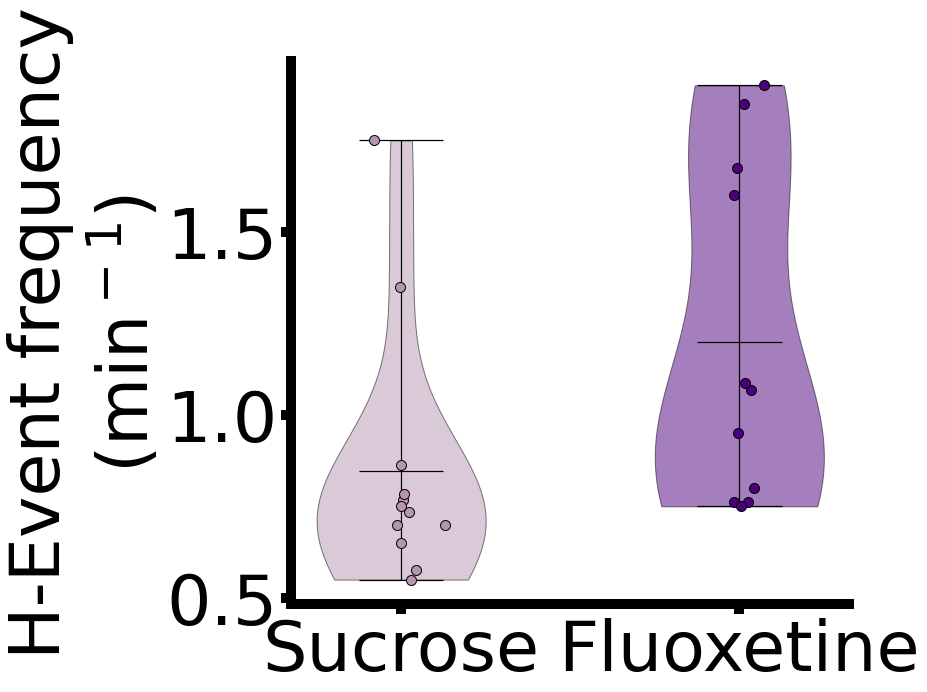

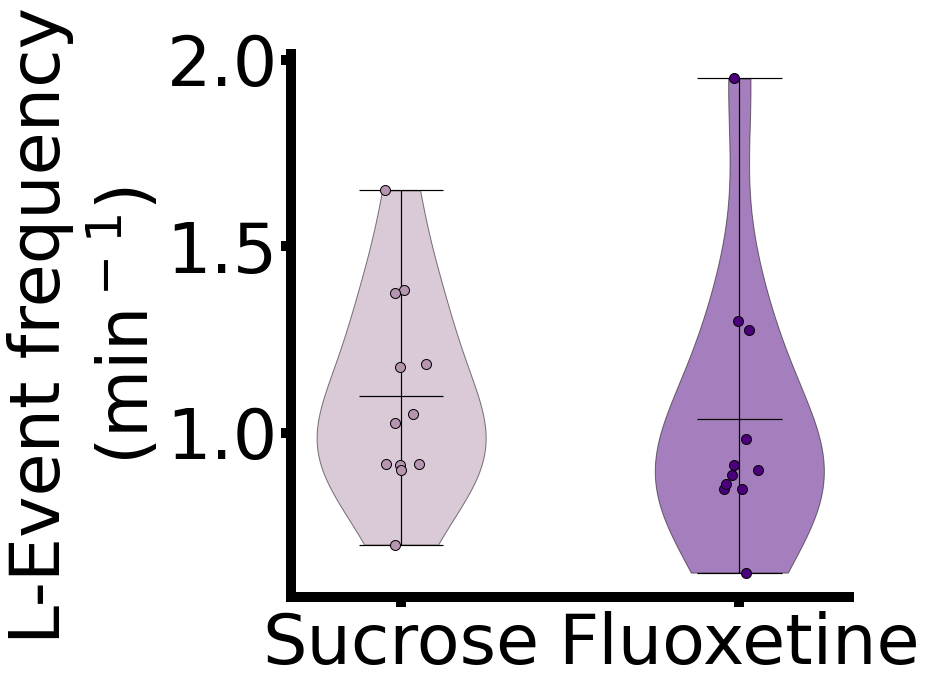

In [196]:
#Number of events violin plot
plt.figure(figsize=(10,10))
PdA.violin_plot(df[df['age']<11],parameter='H_events' , genotypes=['Control','SSRI'], y_label = 'H-Event frequency\n(min$^-$$^1$)', color = [color1,color2],title = None, fontsize = 70)
# x axis label 'Sucrose' and 'Fluoxetine'
plt.xticks([1,2],['Sucrose','Fluoxetine'],fontsize=70)

plt.savefig(Save_path + 'H_events_violin.svg', dpi=300, bbox_inches='tight')
plt.figure(figsize=(10,10))
PdA.violin_plot(df[df['age']<11],parameter='L_events' , genotypes=['Control','SSRI'], y_label = 'L-Event frequency\n(min$^-$$^1$)', color = [color1,color2],title = None, fontsize = 70)
plt.xticks([1,2],['Sucrose','Fluoxetine'],fontsize=70)

plt.savefig(Save_path + 'L_events_violin.svg', dpi=300, bbox_inches='tight')

In [197]:
# Number of H events stats: Significant difference between control and ssri

df_tmp = df[df['age']<11]
#Select only control and ssri
df_tmp = df_tmp[df_tmp['genotype'].isin(['Control','SSRI'])]
#Make control control 0 and ssri 1
df_tmp['genotype'] = df_tmp['genotype'].replace('Control',0)
df_tmp['genotype'] = df_tmp['genotype'].replace('SSRI',1)
#Average across ages for the same animal
df_tmp = df_tmp.groupby(['animal']).mean().reset_index()
#Perform shapiro
print(stats.shapiro(df_tmp[df_tmp['genotype']==0]['H_events']))
#Perform mann whitney u test in control and ssri
print(stats.mannwhitneyu(df_tmp[df_tmp['genotype']==0]['H_events'],df_tmp[df_tmp['genotype']==1]['H_events']))

ShapiroResult(statistic=0.7201182842254639, pvalue=0.0013258057879284024)
MannwhitneyuResult(statistic=26.5, pvalue=0.016329309361315745)


In [198]:
# Number of l events stats: No effect!

df_tmp = df[df['age']<11]
#Select only control and ssri
df_tmp = df_tmp[df_tmp['genotype'].isin(['Control','SSRI'])]
#Make control control 0 and ssri 1
df_tmp['genotype'] = df_tmp['genotype'].replace('Control',0)
df_tmp['genotype'] = df_tmp['genotype'].replace('SSRI',1)
#Average across ages for the same animal
df_tmp = df_tmp.groupby(['animal']).mean().reset_index()
#Perform shapiro
print(stats.shapiro(df_tmp[df_tmp['genotype']==0]['L_events']))
#Perform mann whitney u test in control and ssri
print(stats.mannwhitneyu(df_tmp[df_tmp['genotype']==0]['L_events'],df_tmp[df_tmp['genotype']==1]['L_events']))

ShapiroResult(statistic=0.9382575154304504, pvalue=0.47583410143852234)
MannwhitneyuResult(statistic=89.5, pvalue=0.15659920963440657)


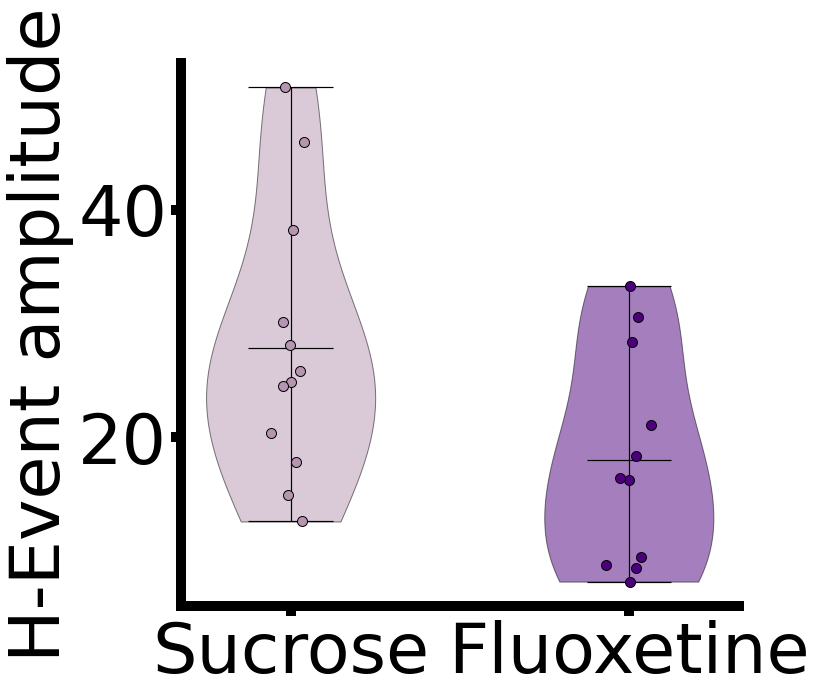

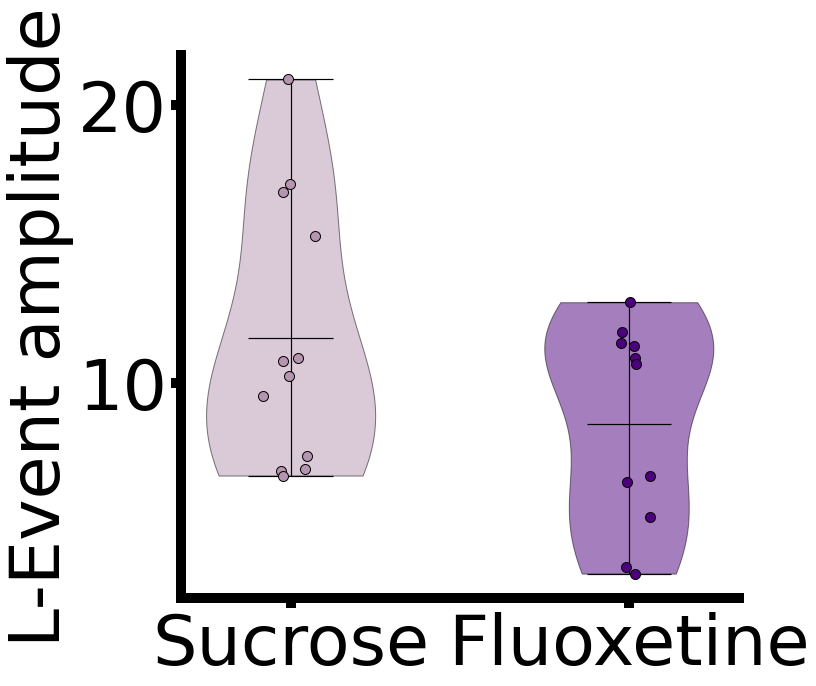

In [199]:
#Number of events violin plot
plt.figure(figsize=(10,10))
PdA.violin_plot(df[df['age']<11],parameter='H_Event_max' , genotypes=['Control','SSRI'], y_label = 'H-Event amplitude', color = [color1,color2],title = None, fontsize = 70)
plt.xticks([1,2],['Sucrose','Fluoxetine'],fontsize=70)
plt.savefig(Save_path + 'H_event_max_violin.svg', dpi=300, bbox_inches='tight')
plt.figure(figsize=(10,10))
PdA.violin_plot(df[df['age']<11],parameter='L_Event_max' , genotypes=['Control', 'SSRI'], y_label = 'L-Event amplitude', color = [color1,color2],title = None, fontsize = 70)
plt.xticks([1,2],['Sucrose','Fluoxetine'],fontsize=70)
plt.savefig(Save_path + 'L_event_max_violin.svg', dpi=300, bbox_inches='tight')

In [200]:
# Number of H events stats: Significant difference between control and ssri

df_tmp = df[df['age']<11]
#Select only control and ssri
df_tmp = df_tmp[df_tmp['genotype'].isin(['Control','SSRI'])]
#Make control control 0 and ssri 1
df_tmp['genotype'] = df_tmp['genotype'].replace('Control',0)
df_tmp['genotype'] = df_tmp['genotype'].replace('SSRI',1)
#Average across ages for the same animal
df_tmp = df_tmp.groupby(['animal']).mean().reset_index()
#Perform shapiro
print(stats.shapiro(df_tmp[df_tmp['genotype']==0]['H_Event_max']))
#Perform mann whitney u test in control and ssri
print(stats.ttest_ind(df_tmp[df_tmp['genotype']==0]['H_Event_max'],df_tmp[df_tmp['genotype']==1]['H_Event_max']))

ShapiroResult(statistic=0.9290245771408081, pvalue=0.3698878586292267)
Ttest_indResult(statistic=2.1845152801262127, pvalue=0.040405325530040725)


In [201]:
# Number of l events stats: No effect, trend maaaybe? p-val --> 0.098

df_tmp = df[df['age']<11]
#Select only control and ssri
df_tmp = df_tmp[df_tmp['genotype'].isin(['Control','SSRI'])]
#Make control control 0 and ssri 1
df_tmp['genotype'] = df_tmp['genotype'].replace('Control',0)
df_tmp['genotype'] = df_tmp['genotype'].replace('SSRI',1)
#Average across ages for the same animal
df_tmp = df_tmp.groupby(['animal']).mean().reset_index()
#Perform shapiro
print(stats.shapiro(df_tmp[df_tmp['genotype']==0]['L_Event_max']))
#Perform mann whitney u test in control and ssri
print(stats.ttest_ind(df_tmp[df_tmp['genotype']==0]['L_Event_max'],df_tmp[df_tmp['genotype']==1]['L_Event_max']))

ShapiroResult(statistic=0.885148286819458, pvalue=0.10205072909593582)
Ttest_indResult(statistic=1.7300702169259479, pvalue=0.09828921778000907)


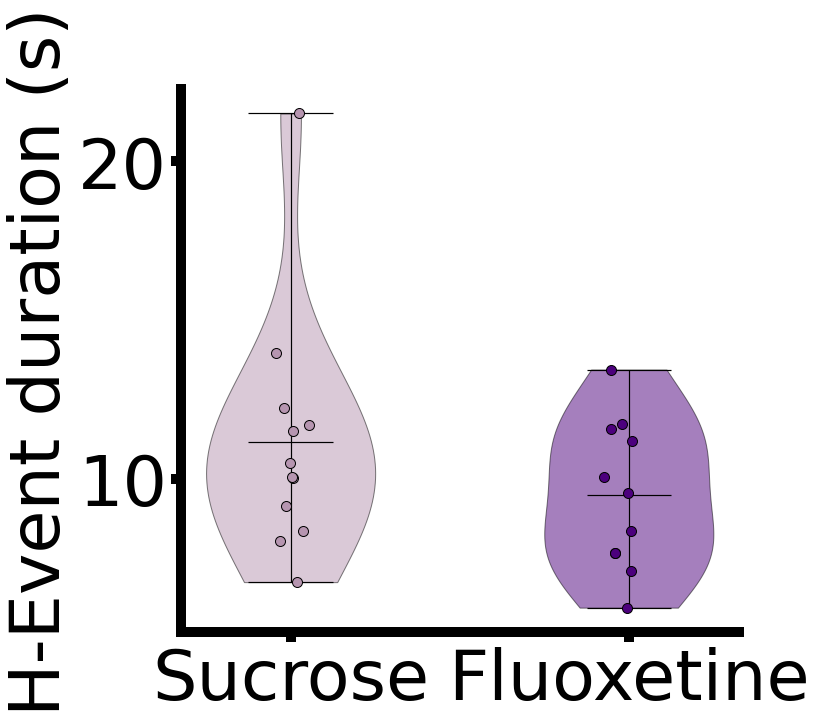

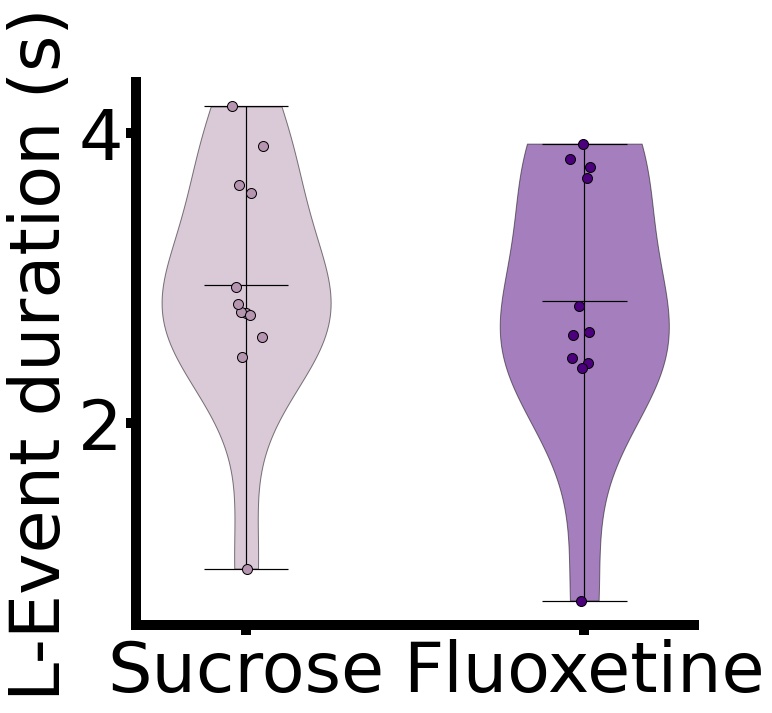

In [202]:
#Number of events violin plot
plt.figure(figsize=(10,10))
PdA.violin_plot(df[df['age']<11],parameter='H_Duration' , genotypes=['Control','SSRI'], y_label = 'H-Event duration (s)', color = [color1,color2],title = None, fontsize = 70)
plt.xticks([1,2],['Sucrose','Fluoxetine'],fontsize=70)
plt.savefig(Save_path + 'H_event_duration_violin.svg', dpi=300, bbox_inches='tight')

plt.figure(figsize=(10,10))
PdA.violin_plot(df[df['age']<11],parameter='L_Duration' , genotypes=['Control','SSRI'], y_label = 'L-Event duration (s)', color = [color1,color2],title = None, fontsize = 70)
plt.xticks([1,2],['Sucrose','Fluoxetine'],fontsize=70)
plt.savefig(Save_path + 'L_event_duration_violin.svg', dpi=300, bbox_inches='tight')

In [203]:
# Number of H events stats: No effect

df_tmp = df[df['age']<11]
#Select only control and ssri
df_tmp = df_tmp[df_tmp['genotype'].isin(['Control','SSRI'])]
#Make control control 0 and ssri 1
df_tmp['genotype'] = df_tmp['genotype'].replace('Control',0)
df_tmp['genotype'] = df_tmp['genotype'].replace('SSRI',1)
#Average across ages for the same animal
df_tmp = df_tmp.groupby(['animal']).mean().reset_index()
#Perform shapiro
print(stats.shapiro(df_tmp[df_tmp['genotype']==0]['H_Duration']))
#Perform mann whitney u test in control and ssri
print(stats.mannwhitneyu(df_tmp[df_tmp['genotype']==0]['H_Duration'],df_tmp[df_tmp['genotype']==1]['H_Duration']))

ShapiroResult(statistic=0.8256170153617859, pvalue=0.018596164882183075)
MannwhitneyuResult(statistic=83.0, pvalue=0.3098652593617933)


In [204]:
# Number of L events stats: No effec

df_tmp = df[df['age']<11]
#Select only control and ssri
df_tmp = df_tmp[df_tmp['genotype'].isin(['Control','SSRI'])]
#Make control control 0 and ssri 1
df_tmp['genotype'] = df_tmp['genotype'].replace('Control',0)
df_tmp['genotype'] = df_tmp['genotype'].replace('SSRI',1)
#Average across ages for the same animal
df_tmp = df_tmp.groupby(['animal']).mean().reset_index()
#Perform shapiro
print(stats.shapiro(df_tmp[df_tmp['genotype']==0]['L_Duration']))
#Perform mann whitney u test in control and ssri
print(stats.ttest_ind(df_tmp[df_tmp['genotype']==0]['L_Duration'],df_tmp[df_tmp['genotype']==1]['L_Duration']))

ShapiroResult(statistic=0.9022585153579712, pvalue=0.16962777078151703)
Ttest_indResult(statistic=0.2907044710183688, pvalue=0.7741289340737703)


## Correlation distance

In [44]:
#To account for correlations in the edge introducing noise, crop
#Make new colomn with cropped traces
df['Correlations_distance_cropped'] = None
for i, row in df.iterrows():
    try:
        df.at[i,'Correlations_distance_cropped'] = np.array(row['Correlations_distance'][:10])
    except:
        pass

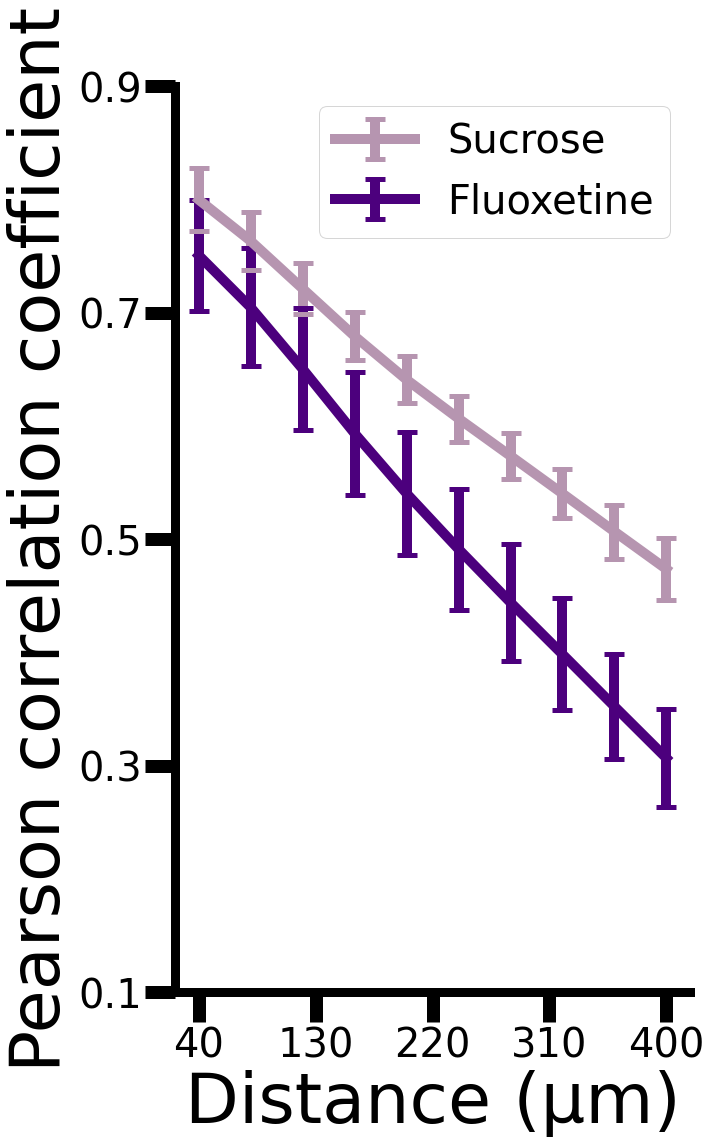

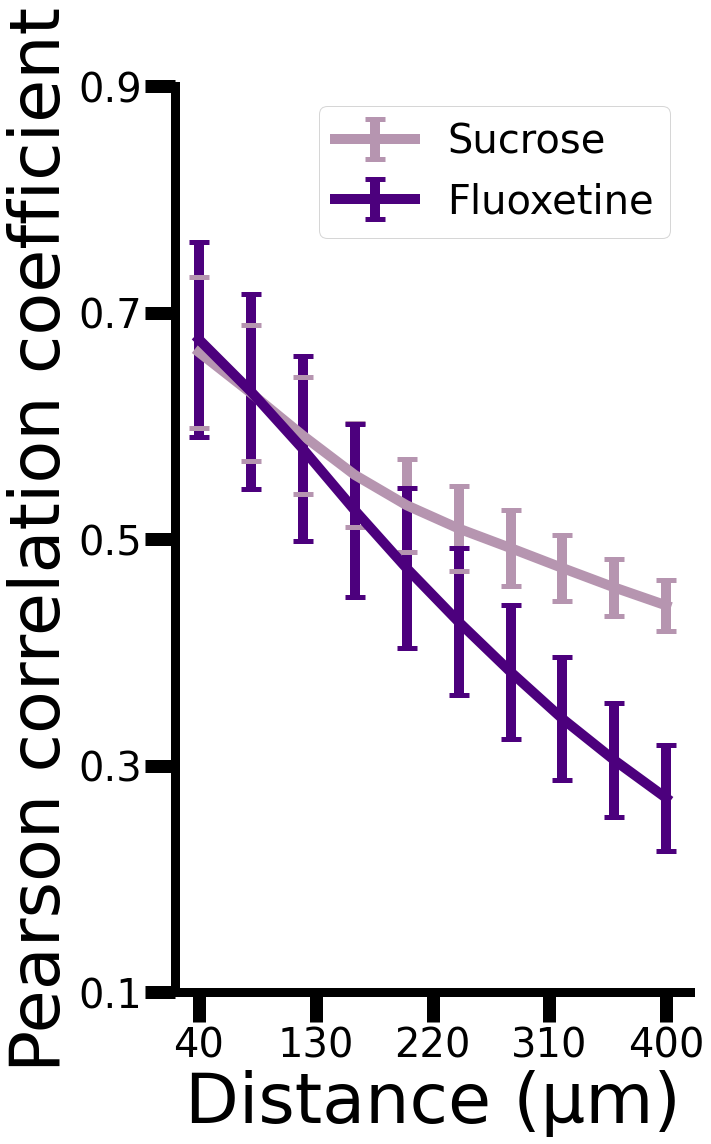

In [62]:
plt.figure(figsize=(10,15))
PdA.Corr_distance_plot(df,parameter='Correlations_distance_cropped', genotypes=['Control','SSRI'], ages=[9], color = [color1,color2],title = None,sp_row=1,sp_colomn=1,sp_number=1)
plt.ylim([0.1,0.85])
leg = plt.legend(['Sucrose','Fluoxetine'],fontsize=40)
for leg in leg.legendHandles:
    leg.set_linewidth(10.0)
#Set xticks from 0 to 10 as 40 to 400
plt.xticks(np.linspace(0,9,5),np.linspace(40,400,5).astype(int),fontsize=40)
plt.yticks(np.arange(0.1,1,0.2),fontsize=40)
#Savefig
plt.savefig(Save_path + 'P9_Correlations_distance.svg',bbox_inches='tight',dpi=300)
plt.figure(figsize=(10,15))
PdA.Corr_distance_plot(df,parameter='Correlations_distance_cropped', genotypes=['Control','SSRI'], ages=[8], color = [color1,color2],title = None,sp_row=1,sp_colomn=1,sp_number=1)
plt.ylim([0.1,0.85])
leg = plt.legend(['Sucrose','Fluoxetine'],fontsize=40)
for leg in leg.legendHandles:
    leg.set_linewidth(10.0)
#Set xticks from 0 to 10 as 40 to 400
plt.xticks(np.linspace(0,9,5),np.linspace(40,400,5).astype(int),fontsize=40)
plt.yticks(np.arange(0.1,1,0.2),fontsize=40)
#Savefig
plt.savefig(Save_path + 'P8_Correlations_distance.svg',bbox_inches='tight',dpi=300)


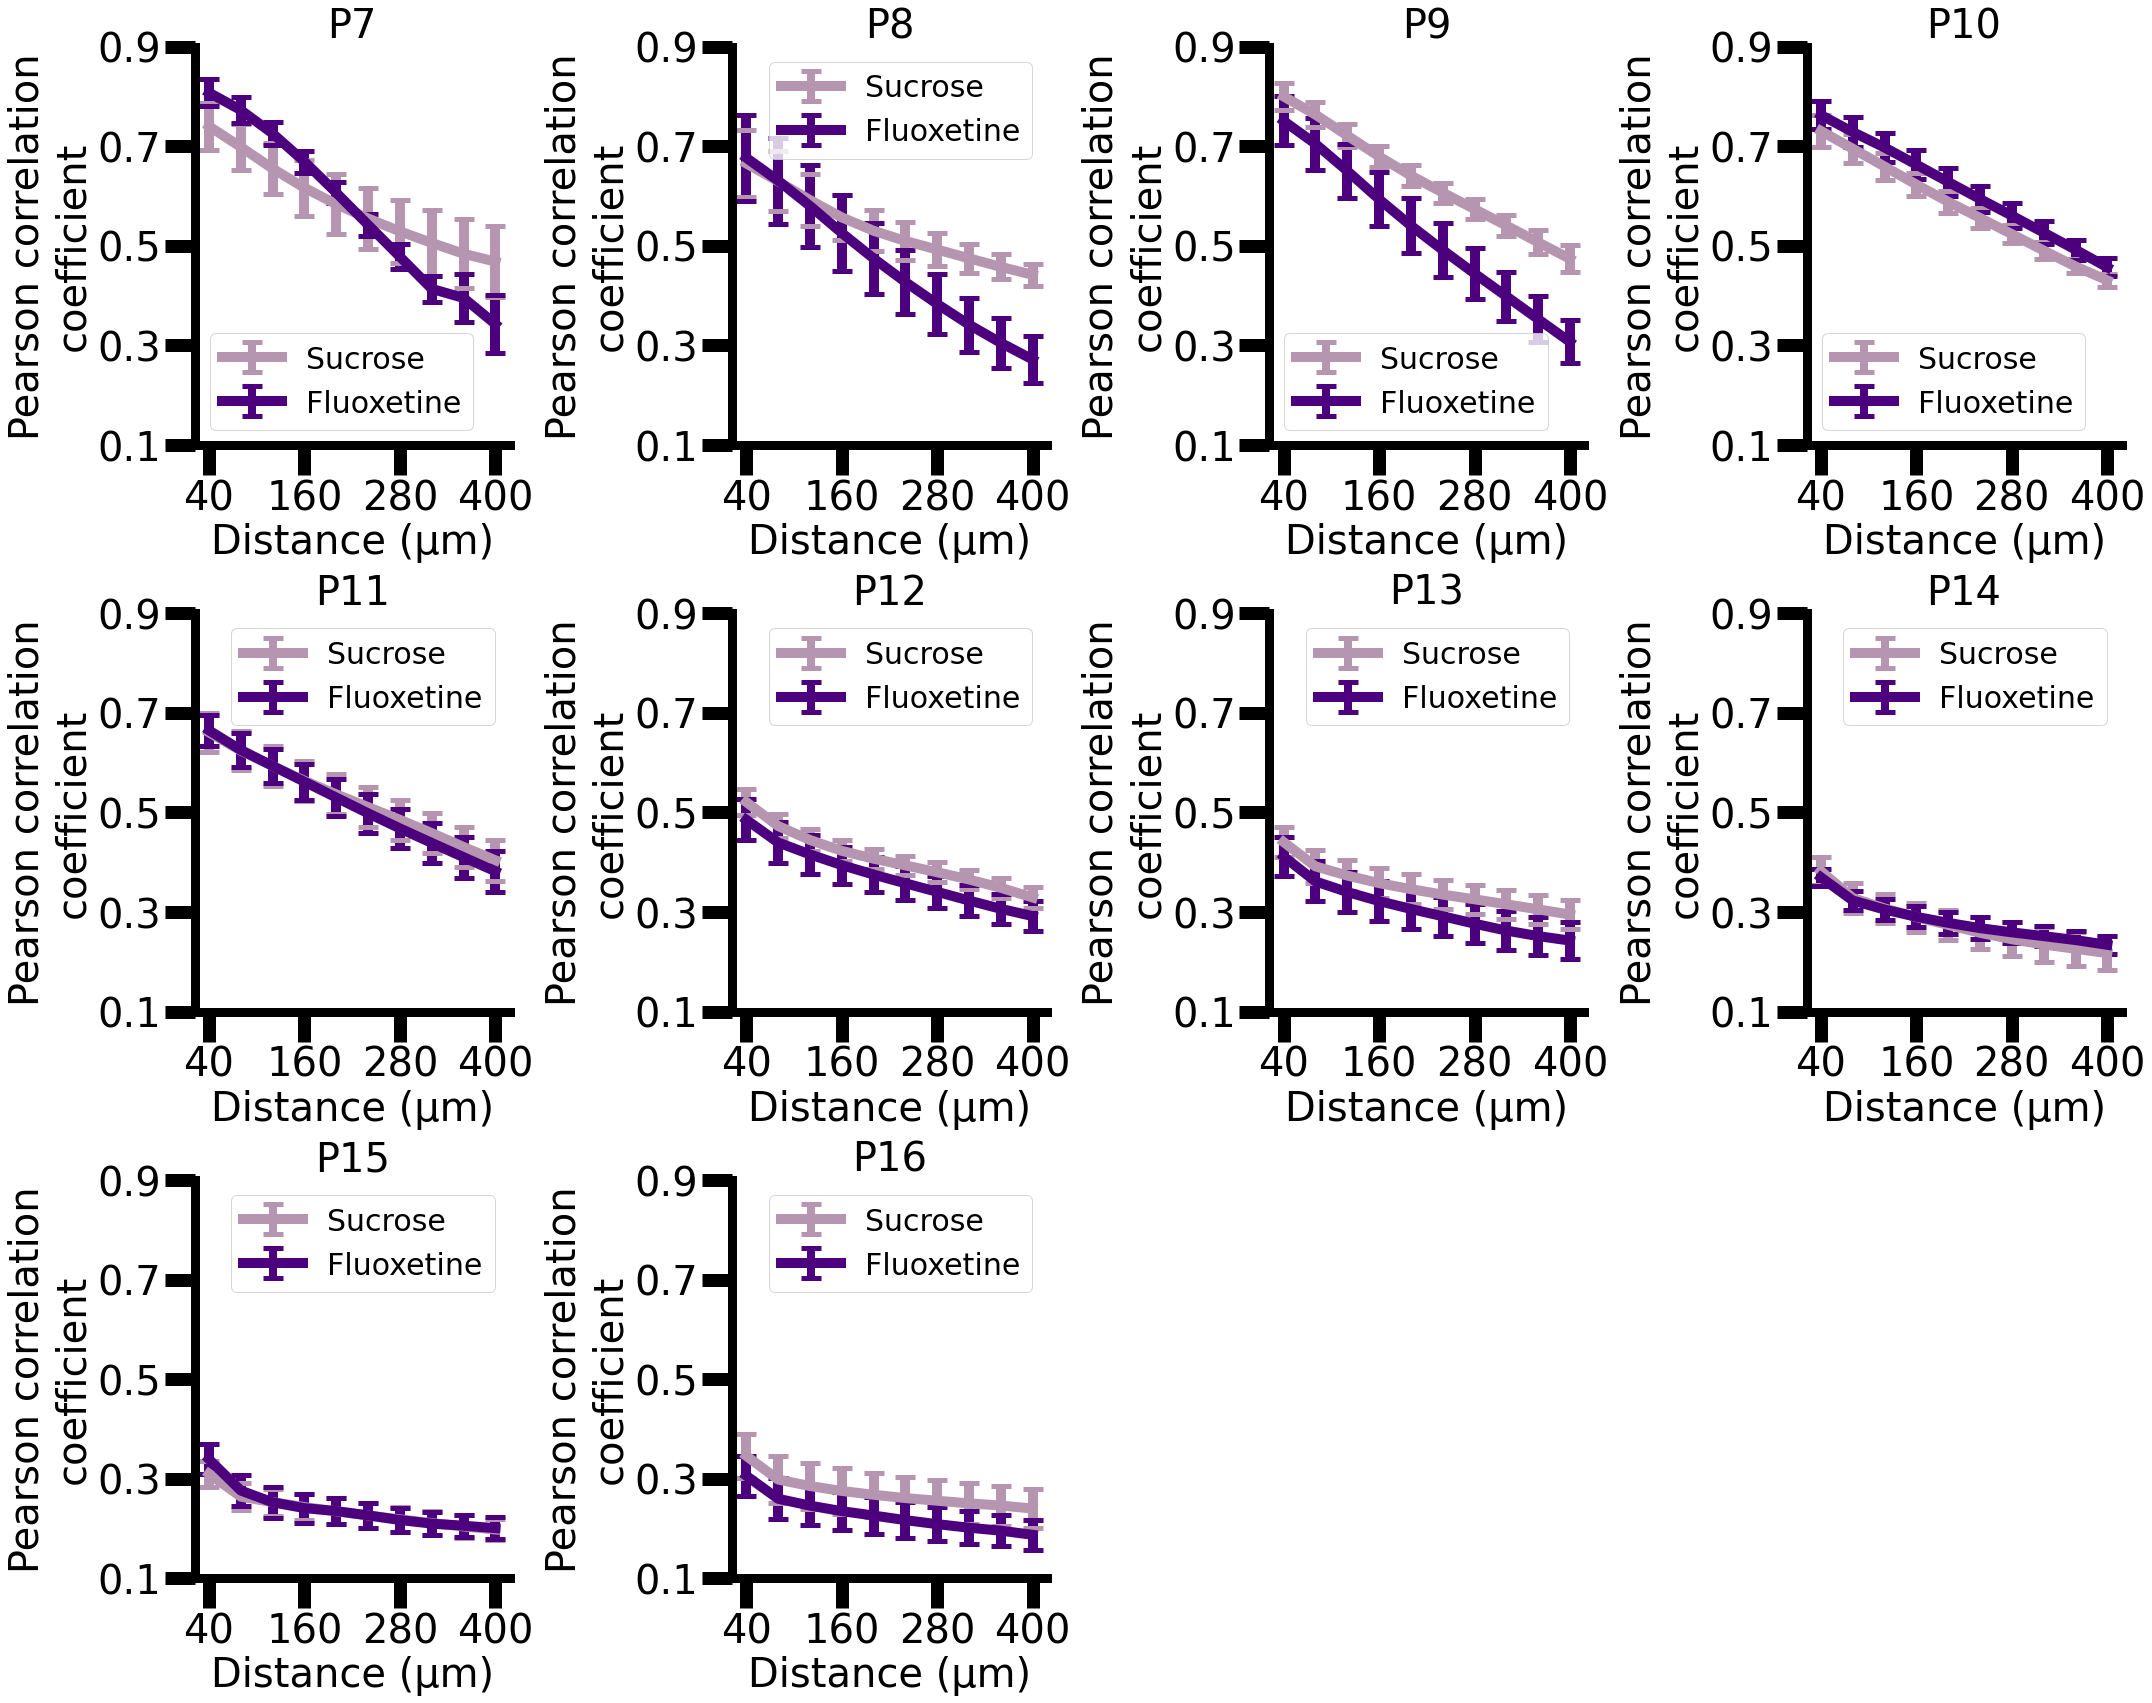

In [63]:
plt.figure(figsize=(30,30))
for i in range(7,17):
    plt.subplot(4,4,i-6)
    PdA.Corr_distance_plot(df,parameter='Correlations_distance_cropped', genotypes=['Control','SSRI'], ages=[i], color = [color1,color2],title = None,sp_row=4,sp_colomn=4,sp_number=i-6)
    plt.ylim([0.1,0.85])
    leg = plt.legend(['Sucrose','Fluoxetine'],fontsize=30)
    for leg in leg.legendHandles:
        leg.set_linewidth(8.0)
    #Set xticks from 0 to 10 as 40 to 400
    plt.xticks(np.linspace(0,9,4),np.linspace(40,400,4).astype(int),fontsize=40)
    plt.yticks(np.arange(0.1,1,0.2),fontsize=40)
    plt.ylabel('Pearson correlation\ncoefficient', fontsize=40)
    plt.title('P' + str(i),fontsize=40)
    plt.xlabel('Distance (μm)',fontsize=40)
    plt.tight_layout()
    
    #Savefig
    plt.savefig(Save_path + 'ALL_Correlations_distance_with_ssri.svg',bbox_inches='tight',dpi=300)

In [51]:
# Anova genotype effect at 9,10,13, But single points only at 9, distance 9/10
for age in range(7,17):
    df_a = df[df['age'] == age]
    #Genotypes WT, HET, KO
    df_a = df_a[df_a['genotype'].isin(['Control','SSRI'])]
    #remove nans
    df_a = df_a[df_a['Correlations_distance_cropped'].notnull()]
    #extract each value in correlation_distance_cropped to a new row with another column named distance that indicates the index of the value, without my own functions
    df_a = df_a.reset_index(drop=True)


    # Melt the dataframe
    df_melted = df_a.explode('Correlations_distance_cropped').reset_index(drop=True)
    df_melted['age'] = np.tile(np.arange(1, 11), len(df_a))
    df_melted.rename(columns={'Correlations_distance_cropped': 'correlation_value'}, inplace=True)
    #Conver to float
    df_melted['correlation_value'] = df_melted['correlation_value'].astype(float)
    print('--------------- Age: ' + str(age) + ' -----------------')
    CaaN.stating(df_melted,'correlation_value',['Control','SSRI'])

    #drop empty and nasn
    df_melted = df_melted[df_melted['correlation_value'].notnull()]
    df_melted = df_melted[df_melted['correlation_value'] != 'None']

    for dist in range(1,11):
        print('Age: ' + str(age) + ' Distance: ' + str(dist))
        #run tukey test
        print('Tukey HSD test results:')
        
        print(tukey.pairwise_tukeyhsd(endog = df_melted[df_melted['age']==dist]['correlation_value'], groups= df_melted[df_melted['age']==dist]['genotype'],alpha=0.05))

        #t test
        print('T-test results:')
        print(stats.ttest_ind(df_melted[df_melted['age']==dist]['correlation_value'][df_melted[df_melted['age']==dist]['genotype']=='Control'],df_melted[df_melted['age']==dist]['correlation_value'][df_melted[df_melted['age']==dist]['genotype']=='SSRI']))
        

--------------- Age: 7 -----------------
Two way ANOVA results:
                      sum_sq    df         F        PR(>F)
C(age)              1.274554   9.0  7.966660  1.020248e-07
C(genotype)         0.002224   1.0  0.125100  7.247676e-01
C(age):C(genotype)  0.109477   9.0  0.684291  7.201724e-01
Residual            1.102126  62.0       NaN           NaN
Shapiro p-val:1.0
Age: 7 Distance: 1
Tukey HSD test results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower  upper  reject
----------------------------------------------------
Control   SSRI   0.0676 0.4018 -0.1157 0.2508  False
----------------------------------------------------
T-test results:
Ttest_indResult(statistic=-0.9020026290274802, pvalue=0.40181204241887525)
Age: 7 Distance: 2
Tukey HSD test results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower  upper  reject
----------------------------------------------------
Control   SSRI   0.074

## Entropy

In [ ]:
Path_df = '//qnap-amp001.dpag.ox.ac.uk/gsantero/Analysis/Data_frames/With_data/'
file_name = '2023_10_24_df_data_INT'

#import 2023_03_18_df_cumsum as df_cumsum using pickle
with open(Path_df + file_name,'rb') as handle:
    df = pickle.load(handle)



df['interneuron'] = df['interneuron'].replace('NKx2.1','Nkx2.1')
df['genotype'] = df['genotype'].replace('KO ','KO')
df['genotype'] = df['genotype'].replace('HET ','HET')
df['genotype'] = df['genotype'].replace('WT ','WT')
df['genotype'] = df['genotype'].replace('WT?','WT')

#extract_to_separate_coloumn number of neurons to separate coloumn
df = PdA.extract_to_separate_coloumn(df,'Number_of_neurons',0,'Neurons')
df = PdA.extract_to_separate_coloumn(df, 'Whisker_responses',-3,'Proportion_resp')
for n in range(0,10):
    df = PdA.extract_to_separate_coloumn(df, 'Whisker_responses',n,'Resp' + str((n+1)*10) + '%')
for n in range(0,10):
    df = PdA.extract_to_separate_coloumn(df, 'Airpuff_responses',n,'AResp' + str((n+1)*10) + '%')
df = PdA.extract_to_separate_coloumn(df, 'Whisker_responses',-3,'Whisker_responsive')
df = PdA.extract_to_separate_coloumn(df, 'Airpuff_responses',-3,'Airpuff_responsive')


#Remove rows with less than 500 neuorns and print how many where removed
print('Number of rows removed: ' + str(len(df[df['Neurons'] < 500])))
#df = df[df['Neurons'] >= 500]

#remove runt 351 (died at P10 very underweighted)
df = df[df['animal'] != 'GOS351']
df.head(n=10)

#remove GOS464 ONWARDS (WT dams)
df = df[df['animal'] != 'GOS466']
df = df[df['animal'] != 'GOS470']
df = df[df['animal'] != 'GOS471']



Number of rows removed: 54


In [190]:
df['Entropy_n'] = None
for i,row in df.iterrows():
    try:
        df.at[i,'Entropy_n'] = row['Entropy'] / row['Neurons']
    except:
        pass

SERTKO Age: 7
MannwhitneyuResult(statistic=36.0, pvalue=1.0)
SERTKO Age: 8
MannwhitneyuResult(statistic=36.0, pvalue=0.08128565937470517)
SERTKO Age: 9
MannwhitneyuResult(statistic=42.0, pvalue=0.7747435270104788)
SERTKO Age: 10
MannwhitneyuResult(statistic=34.5, pvalue=0.33770855125007204)
SERTKO Age: 11
MannwhitneyuResult(statistic=32.0, pvalue=0.03352308715887636)
SERTKO Age: 12
Ttest_indResult(statistic=-0.33826281884182424, pvalue=0.7386902556484698)
SERTKO Age: 13
Ttest_indResult(statistic=-0.36671609465222904, pvalue=0.7178829904480248)
SERTKO Age: 14
Ttest_indResult(statistic=-0.8614397984173014, pvalue=0.4003263173891729)
SERTKO Age: 15
Ttest_indResult(statistic=0.1271770350189227, pvalue=0.9006088765916129)
SERTKO Age: 16
Ttest_indResult(statistic=1.1219144386797377, pvalue=0.28384669717928646)


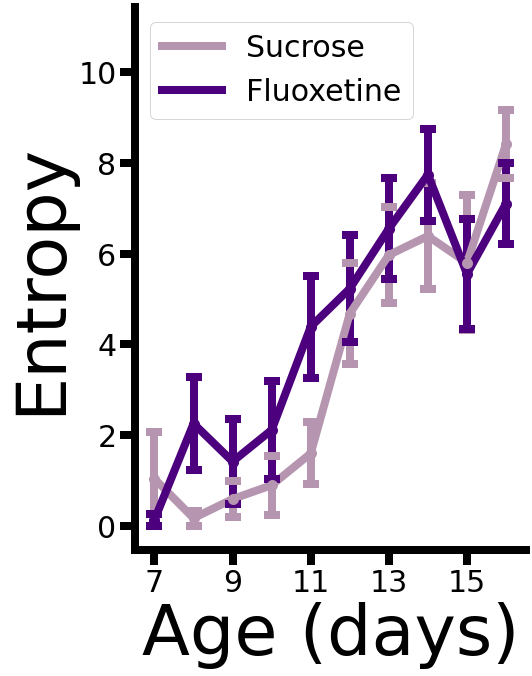

In [35]:
plt.figure(figsize=(7,10))
PdA.developmental_plot_errorbars(df,'Entropy',y_label='Entropy', genotype=['Control','SSRI'],color=[color1,color2])
plt.legend(['Sucrose','Fluoxetine'],fontsize=30)
plt.ylabel('Entropy',fontsize=70)
plt.xlabel('Age (days)',fontsize=70)
plt.xlim([-0.5,9.5])
plt.savefig(Save_path + 'Entropy_across_dev_SSRI.svg',dpi=300,bbox_inches='tight')
#Run stats
#stating(df,'Entropy',genotypes=['WT','HET','KO']) (0.0, 0.823, 0.016)
for age in range(7,17):
    print('SERTKO Age: ' + str(age))
    df_tmp = df[df['age']==age]
    # Choose only Control and SSRI
    df_tmp = df_tmp[df_tmp['genotype'].isin(['Control','SSRI'])]
    #Make float entropy
    df_tmp['Entropy'] = df_tmp['Entropy'].astype(float)
    #Remove none and nans on entropy
    df_tmp = df_tmp[df_tmp['Entropy'].notnull()]
    #Select only WT, HET, KO
    #Run shapiro
    a,b = stats.shapiro(df_tmp[df_tmp['genotype']=='Control']['Entropy'])
    if b < 0.05:
        #mann whitney u test
        print(stats.mannwhitneyu(df_tmp[df_tmp['genotype']=='Control']['Entropy'],df_tmp[df_tmp['genotype']=='SSRI']['Entropy']))
    else:
        #t test
        print(stats.ttest_ind(df_tmp[df_tmp['genotype']=='Control']['Entropy'],df_tmp[df_tmp['genotype']=='SSRI']['Entropy']))

    
    

ShapiroResult(statistic=0.6567495465278625, pvalue=0.0003330739273224026)
MannwhitneyuResult(statistic=37.0, pvalue=0.04076169682456686)


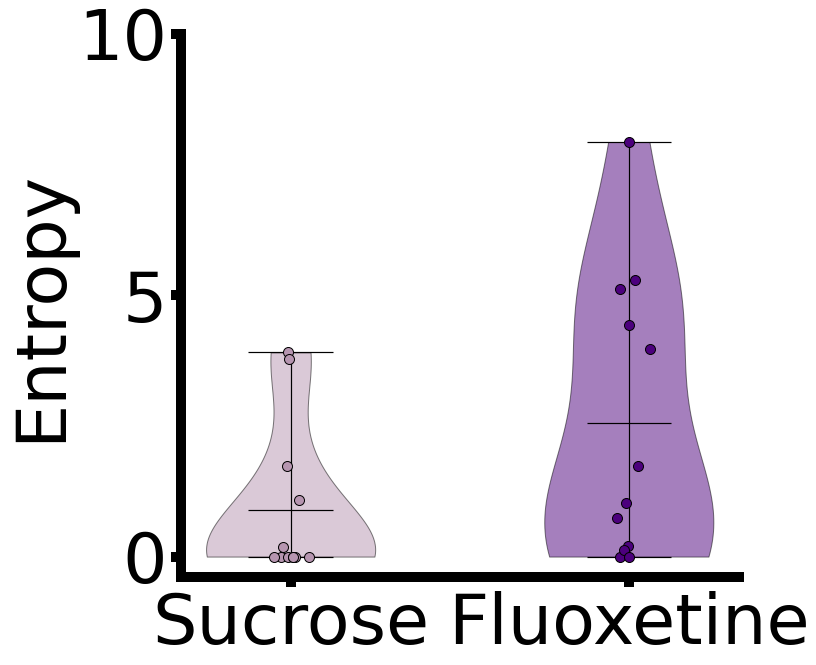

In [191]:
#Control and SSRI
plt.figure(figsize=(10,10))
PdA.violin_plot(df[df['age']<12],'Entropy',y_label='Entropy', genotypes=['Control','SSRI'],color=[color1,color2])
plt.xticks([1,2],['Sucrose','Fluoxetine'],fontsize=70)
plt.yticks([0,5,10],fontsize=70)
plt.savefig(Save_path + 'Entropy_p7-10_SSRI.svg',dpi=300,bbox_inches='tight')
df_tmp = df[df['age']<12]
#Select only Control, SSRI
df_tmp = df_tmp[df_tmp['genotype']!='WT']
df_tmp = df_tmp[df_tmp['genotype']!='HET']
df_tmp = df_tmp[df_tmp['genotype']!='KO']
#Replace genotype by 0,1,2
df_tmp['genotype'] = df_tmp['genotype'].replace('Control',0)
df_tmp['genotype'] = df_tmp['genotype'].replace('SSRI',1)
#Make entropy float
df_tmp['Entropy'] = df_tmp['Entropy'].astype(float)
#Group by animal
df_tmp = df_tmp.groupby(['animal']).mean()
#Shapiro
print(stats.shapiro(df_tmp[df_tmp['genotype']==0]['Entropy']))
#One way mann whitney u
print(stats.mannwhitneyu(df_tmp[df_tmp['genotype']==0]['Entropy'],df_tmp[df_tmp['genotype']==1]['Entropy']))




## Whisker response

ShapiroResult(statistic=0.9727033376693726, pvalue=0.9369576573371887)
Ttest_indResult(statistic=2.575395628248565, pvalue=0.01763990484645507)


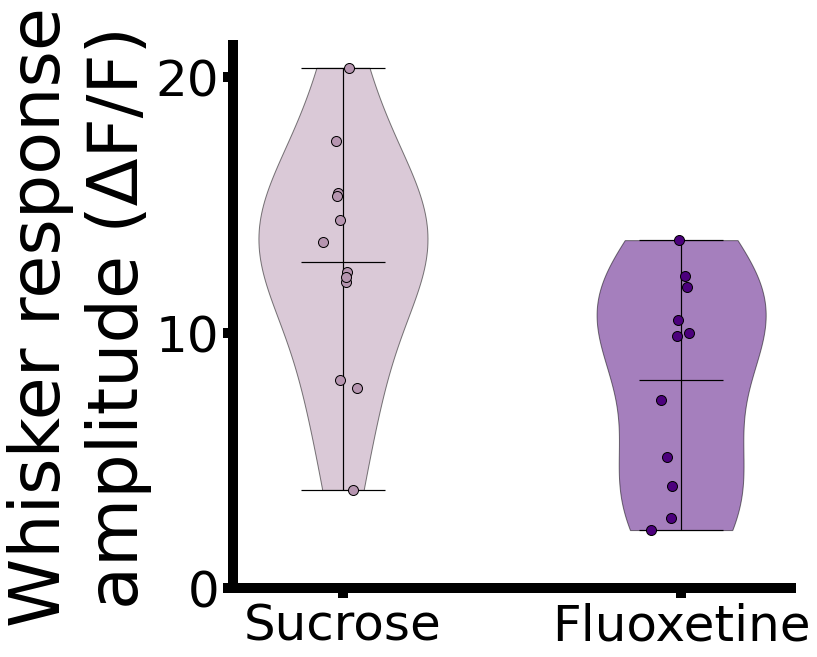

In [187]:
#7-10 response
df_control_SSRI = df[(df['genotype']=='Control') | (df['genotype']=='SSRI')]
#Replace control for 0 and ssri for 1
df_control_SSRI = df_control_SSRI.replace('Control',0)
df_control_SSRI = df_control_SSRI.replace('SSRI',1)
#select age <11
df_control_SSRI = df_control_SSRI[(df_control_SSRI['age']<11)]# & (df_control_SSRI['age']<17)]

#Mean across ages
df_control_SSRI = df_control_SSRI.groupby(['animal']).mean()
#Remove nans in whisker response AUC
df_control_SSRI = df_control_SSRI[df_control_SSRI['Whisker_response_AUC_cropped'].notnull()]
#shapiro
print(stats.shapiro(df_control_SSRI[df_control_SSRI['genotype']==0]['Whisker_response_AUC_cropped']))
#Run t test
print(stats.ttest_ind(df_control_SSRI[df_control_SSRI['genotype']==0]['Whisker_response_AUC_cropped'],df_control_SSRI[df_control_SSRI['genotype']==1]['Whisker_response_AUC_cropped']))
#Plot violin plot
plt.figure(figsize=(10,10))
PdA.violin_plot(df[(df['age']<11)],parameter='Whisker_response_AUC_cropped' , genotypes=['Control','SSRI'], y_label = 'Whisker response\namplitude (ΔF/F)', color = [color1,color2],title = None, fontsize = 70)

#set  xticks as 'Sucrose' and 'Fluoxetine'
plt.yticks(np.arange(0,21,10),fontsize=50)
plt.xticks([1,2],['Sucrose','Fluoxetine'],fontsize=50)
plt.savefig(Save_path + 'P7_10_Whisker_response_amplitude_violin.svg', dpi=300, bbox_inches='tight')

T-test: Ttest_indResult(statistic=0.3163716973409435, pvalue=0.7548436589235672)


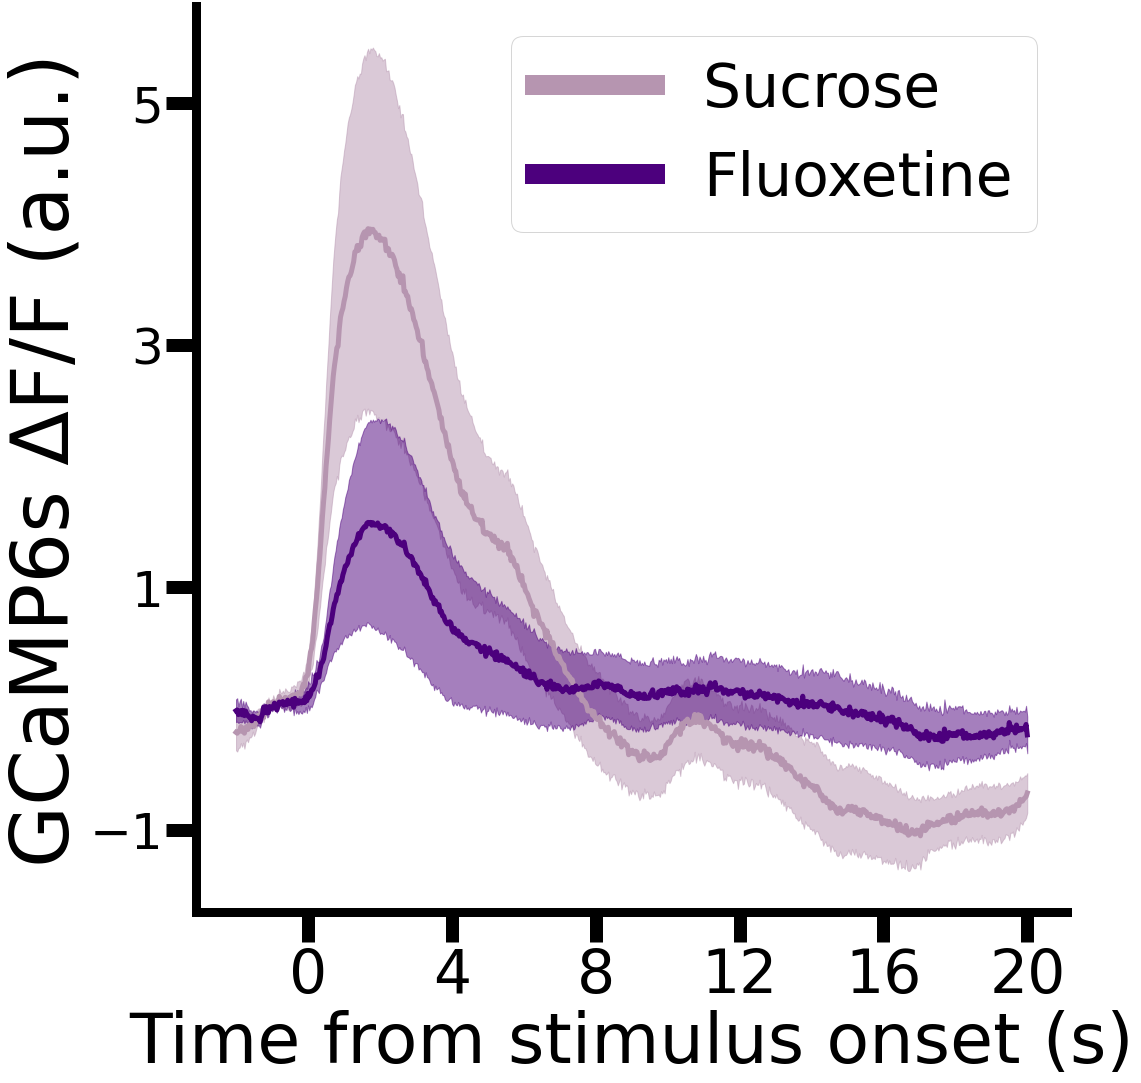

In [98]:
#14-16 response
df['Whisker_response_trace_cropped'] = None
for i, row in df.iterrows():

        try:
            df.at[i,'Whisker_response_trace_cropped'] = row['Whisker_response_trace'][:660]
        except:
            pass
plt.figure(figsize=(15,15))
PdA.Response(df,parameter='Whisker_response_trace_cropped', length = 660, genotypes=['Control','SSRI'], ages=[7,8,9,10], color = [color1,color2],title = None,sp_row=1,sp_colomn=1,sp_number=1,stat = np.nanmean)

leg = plt.legend(['Sucrose','Fluoxetine'],fontsize=60)
for leg in leg.legendHandles:
    leg.set_linewidth(20)
plt.xlabel('Time from stimulus onset (s)',fontsize=70)
#replace x ticks at time 0,60,120,.. 660 with -2,0,2,.. 20
plt.xticks(np.linspace(0,600,6),np.linspace(0,20,6).astype(int),fontsize=60)
plt.yticks(np.arange(-1,5.1,2),fontsize=50)
plt.ylabel('GCaMP6s ΔF/F (a.u.)',fontsize=80)

#save figure
plt.savefig(Save_path + 'Whisker_response_22s_p17-10.svg',dpi=300,bbox_inches='tight',format='svg')


T-test: Ttest_indResult(statistic=-3.080154992240922, pvalue=0.005676515030314532)


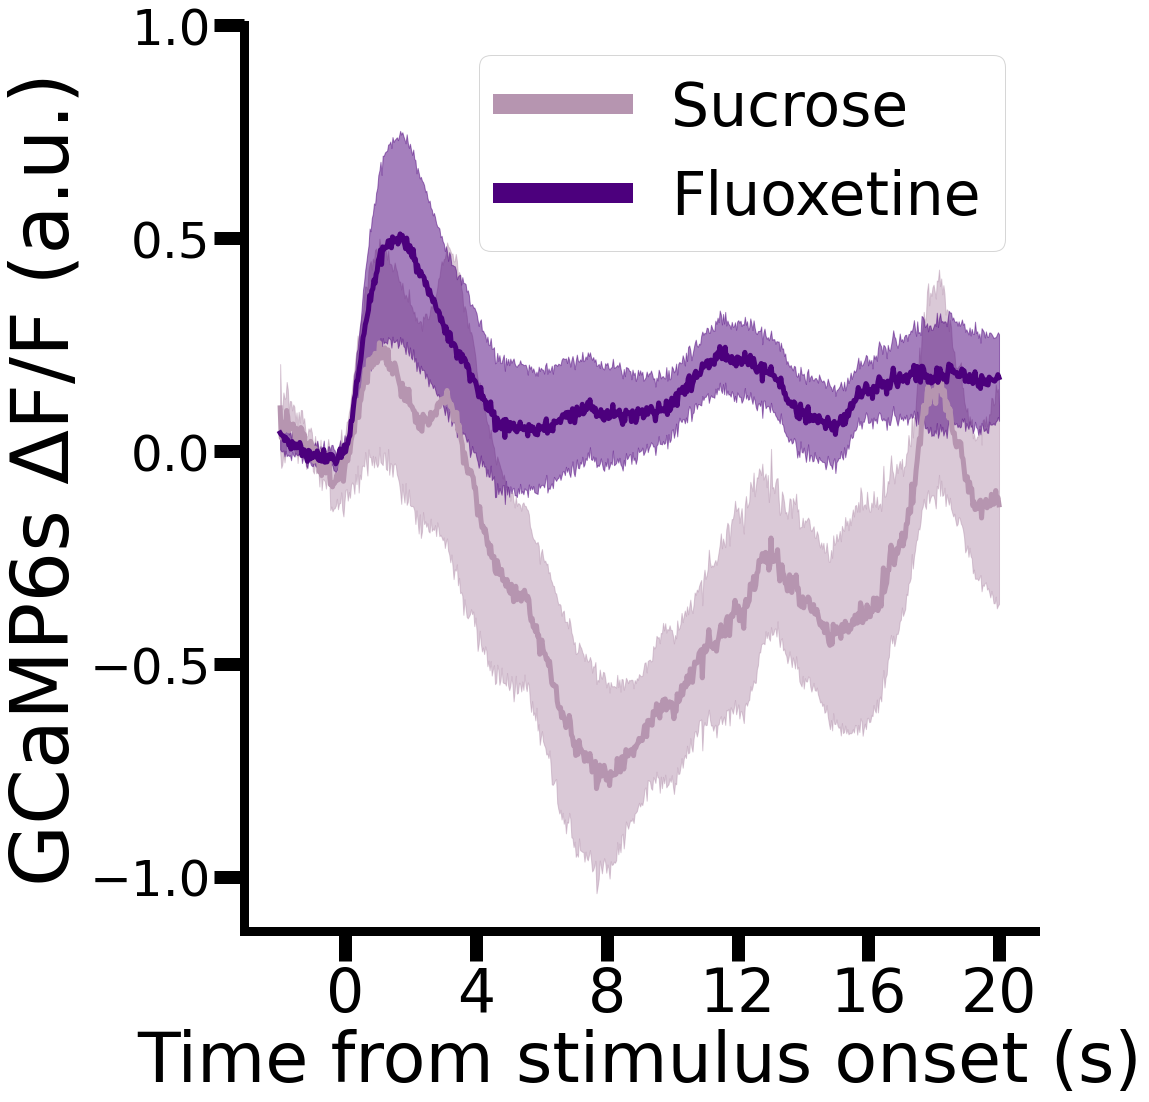

In [83]:
#11-13 response
df['Whisker_response_trace_cropped'] = None
for i, row in df.iterrows():

        try:
            df.at[i,'Whisker_response_trace_cropped'] = row['Whisker_response_trace'][:660]
        except:
            pass
plt.figure(figsize=(15,15))
PdA.Response(df,parameter='Whisker_response_trace_cropped', length = 660, genotypes=['Control','SSRI'], ages=[11,12,13], color = [color1,color2],title = None,sp_row=1,sp_colomn=1,sp_number=1,stat = np.nanmean)

leg = plt.legend(['Sucrose','Fluoxetine'],fontsize=60)
for leg in leg.legendHandles:
    leg.set_linewidth(20)
plt.xlabel('Time from stimulus onset (s)',fontsize=70)
#replace x ticks at time 0,60,120,.. 660 with -2,0,2,.. 20
plt.xticks(np.linspace(0,600,6),np.linspace(0,20,6).astype(int),fontsize=60)
plt.yticks(np.arange(-1,1.1,0.5),fontsize=50)
plt.ylabel('GCaMP6s ΔF/F (a.u.)',fontsize=80)

#save figure
plt.savefig(Save_path + 'Whisker_response_22s_p11-13.svg',dpi=300,bbox_inches='tight',format='svg')


c:\Users\gabrielos\anaconda3\lib\site-packages\pandas\core\missing.py:94: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= arr == x


ShapiroResult(statistic=0.7597315311431885, pvalue=0.007028515916317701)
MannwhitneyuResult(statistic=34.0, pvalue=0.2544505826463366)


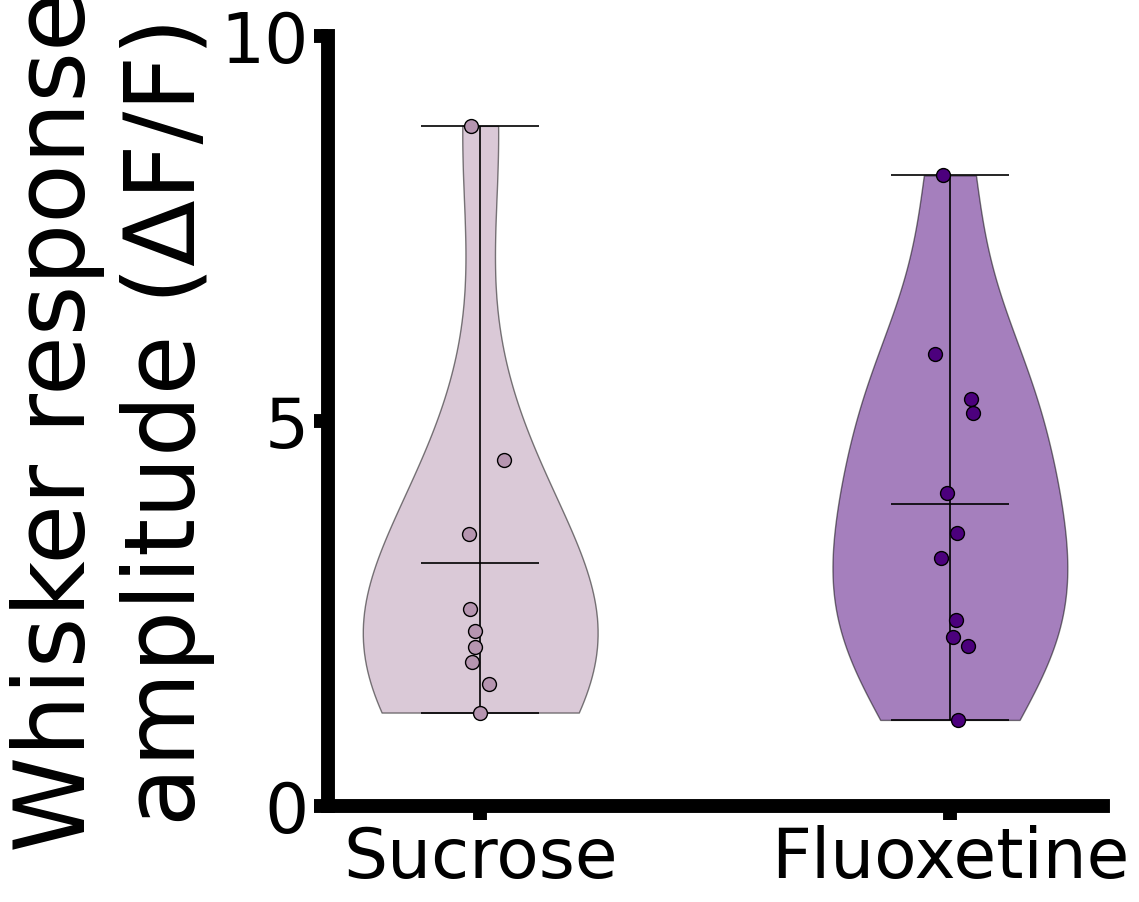

In [47]:
#7-10 response
df_control_SSRI = df[(df['genotype']=='Control') | (df['genotype']=='SSRI')]
#Replace control for 0 and ssri for 1
df_control_SSRI = df_control_SSRI.replace('Control',0)
df_control_SSRI = df_control_SSRI.replace('SSRI',1)
#select age <11
df_control_SSRI = df_control_SSRI[(df_control_SSRI['age']>11) & (df_control_SSRI['age']<14)]

#Mean across ages
df_control_SSRI = df_control_SSRI.groupby(['animal']).mean()
#Remove nans in whisker response AUC
df_control_SSRI = df_control_SSRI[df_control_SSRI['Whisker_response_AUC_cropped'].notnull()]
#shapiro
print(stats.shapiro(df_control_SSRI[df_control_SSRI['genotype']==0]['Whisker_response_AUC_cropped']))
#Run t test
print(stats.mannwhitneyu(df_control_SSRI[df_control_SSRI['genotype']==0]['Whisker_response_AUC_cropped'],df_control_SSRI[df_control_SSRI['genotype']==1]['Whisker_response_AUC_cropped']))
#Plot violin plot
plt.figure(figsize=(10,10))
df_tmp = df[(df['age']>11) & (df['age']<14)]
#remove nans
df_tmp = df_tmp[df_tmp['Whisker_response_AUC_cropped'].notnull()]
PdA.violin_plot(df_tmp,parameter='Whisker_response_AUC_cropped' , genotypes=['Control','SSRI'], y_label = 'Whisker response\namplitude (ΔF/F)', color = [color1,color2],title = None, fontsize = 70)

#set  xticks as 'Sucrose' and 'Fluoxetine'
plt.yticks(np.arange(0,10.1,5),fontsize=50)
plt.xticks([1,2],['Sucrose','Fluoxetine'],fontsize=50)
plt.savefig(Save_path + 'P11_13_Whisker_response_amplitude_violin.svg', dpi=300, bbox_inches='tight')

## Interneurons

### Import interneuron single cell data

In [ ]:
Path_df = '//qnap-amp001.dpag.ox.ac.uk/gsantero/Analysis/Data_frames/With_data/'
file_name = '2023_10_23_df_data_interneuron' 
#import 2023_03_18_df_cumsum as df_cumsum using pickle
with open(Path_df + file_name,'rb') as handle:
    df = pickle.load(handle)

df['interneuron'] = df['interneuron'].replace('NKx2.1','Nkx2.1')
df['genotype'] = df['genotype'].replace('KO ','KO')
df['genotype'] = df['genotype'].replace('HET ','HET')
df['genotype'] = df['genotype'].replace('WT ','WT')
df['genotype'] = df['genotype'].replace('WT?','WT')

#extract_to_separate_coloumn number of neurons to separate coloumn
df = PdA.extract_to_separate_coloumn(df,'Number_of_neurons',0,'Neurons')


#Remove rows with less than 500 neuorns and print how many where removed
print('Number of rows removed: ' + str(len(df[df['Neurons'] < 500])))
df = df[df['Neurons'] >= 500]

#remove runt 351 (died at P10 very underweighted)
df = df[df['animal'] != 'GOS351']
df.head(n=10)

#remove GOS464 ONWARDS (WT dams)
df = df[df['animal'] != 'GOS466']
df = df[df['animal'] != 'GOS470']
df = df[df['animal'] != 'GOS471']


Number of rows removed: 54


### Event analysis

C:\Users\GABRIE~1\AppData\Local\Temp/ipykernel_111716/742668741.py:9: RuntimeWarning: All-NaN slice encountered
  tmp = np.nanmax(row['Interneurons_events_single_neuron_t001']['Peri_H'],2)
C:\Users\GABRIE~1\AppData\Local\Temp/ipykernel_111716/742668741.py:10: RuntimeWarning: All-NaN slice encountered
  tmp2 = np.nanmax(row['Interneurons_events_single_neuron_t001']['Peri_L'],2)


WT: 870
HET: 576
ShapiroResult(statistic=0.7142184972763062, pvalue=4.956551855822425e-36)
MannwhitneyuResult(statistic=257082.0, pvalue=0.4015006009754972)


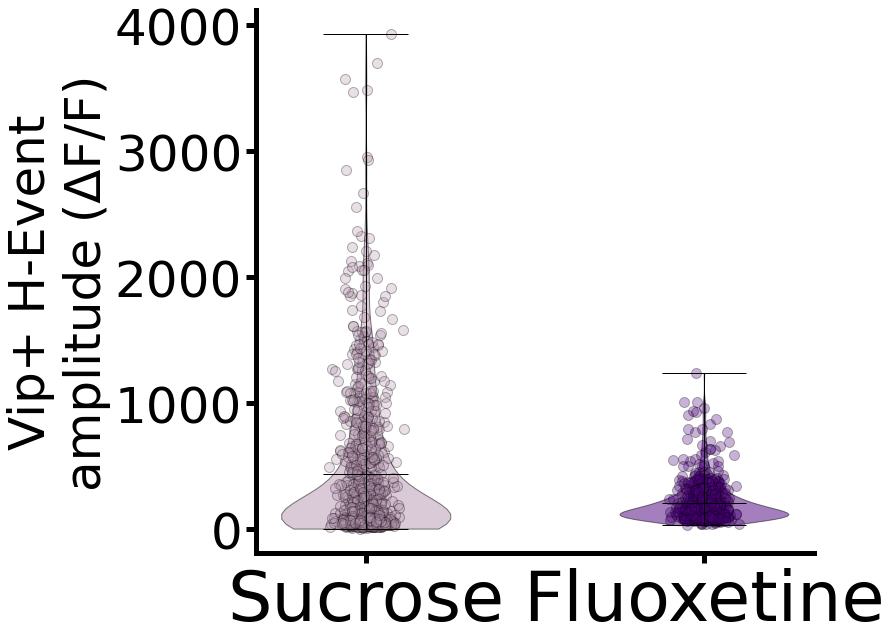

In [111]:
Control = []
SSRI = []


for age in range(7,11):
    df_a = df[df['age']==age]
    for i,row in df_a[df_a['interneuron']=='Vip'].iterrows():
        try:
            tmp = np.nanmax(row['Interneurons_events_single_neuron_t001']['Peri_H'],2)
            tmp2 = np.nanmax(row['Interneurons_events_single_neuron_t001']['Peri_L'],2)
    
            if row['genotype'] == 'Control':
                Control.append(tmp[:,0])#/tmp[:,1])
            if row['genotype'] == 'SSRI':
                SSRI.append(tmp[:,0])#/tmp[:,1])

        except:
            pass
try:
    Control = (np.hstack(Control)).astype(float)
    SSRI = (np.hstack(SSRI)).astype(float)

except:
    pass



#Violin plot of WT,HET,KO
plt.figure(figsize=(10,10))
#Make 0 nans in WT,HET,KO
Control[Control==0] = np.nan
SSRI[SSRI==0] = np.nan


violin = plt.violinplot([Control[~np.isnan(Control)]],positions=[1],showmeans=True,showextrema=True)
violin2 = plt.violinplot([SSRI],positions=[2],showmeans=True,showextrema=True)


#set all edges black
for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = violin[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
    vp = violin2[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)

#color violin plot faces
for pc in violin['bodies']:
    pc.set_facecolor(color1)
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)
for pc in violin2['bodies']:
    pc.set_facecolor(color2)
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)


    
#scatter points on top
plt.scatter(np.ones(Control.shape[0])+np.random.normal(1,0.035,Control.shape[0])-1,Control,color=color1,edgecolors='black',s=100, alpha=0.3)
plt.scatter(np.ones(SSRI.shape[0])+np.random.normal(1,0.035,SSRI.shape[0]),SSRI,color=color2,edgecolors='black',s=100, alpha=0.3)

#Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#Set x and y ticks size
plt.xticks(fontsize=70)
plt.yticks(fontsize=50)
#Set x and y labels
plt.xticks([1,2],['Sucrose','Fluoxetine'],fontsize=70)
plt.ylabel('Vip+ H-Event\namplitude (ΔF/F)',fontsize=50)

#Make axis thicker
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
#make ticks longer and wider
ax.tick_params(width=5,length=10)

plt.savefig(Save_path + 'VIP_H_event_amplitude.svg',dpi=300,bbox_inches='tight', format='svg')

#Print lengths of each genotype
print('WT: ' + str(Control.shape[0]))
print('HET: ' + str(SSRI.shape[0]))

#Shapiro test
print(stats.shapiro(Control[~np.isnan(Control)]))
#Krustal wallis
print(stats.mannwhitneyu(Control[~np.isnan(Control)],SSRI[~np.isnan(SSRI)]))


C:\Users\GABRIE~1\AppData\Local\Temp/ipykernel_111716/1811149663.py:10: RuntimeWarning: All-NaN slice encountered
  tmp2 = np.nanmax(row['Interneurons_events_single_neuron_t001']['Peri_L'],2)
C:\Users\GABRIE~1\AppData\Local\Temp/ipykernel_111716/1811149663.py:9: RuntimeWarning: All-NaN slice encountered
  tmp = np.nanmax(row['Interneurons_events_single_neuron_t001']['Peri_H'],2)


WT: 1291
HET: 775
ShapiroResult(statistic=0.8322806358337402, pvalue=8.991176636250318e-35)
MannwhitneyuResult(statistic=440357.5, pvalue=5.038890227816619e-06)


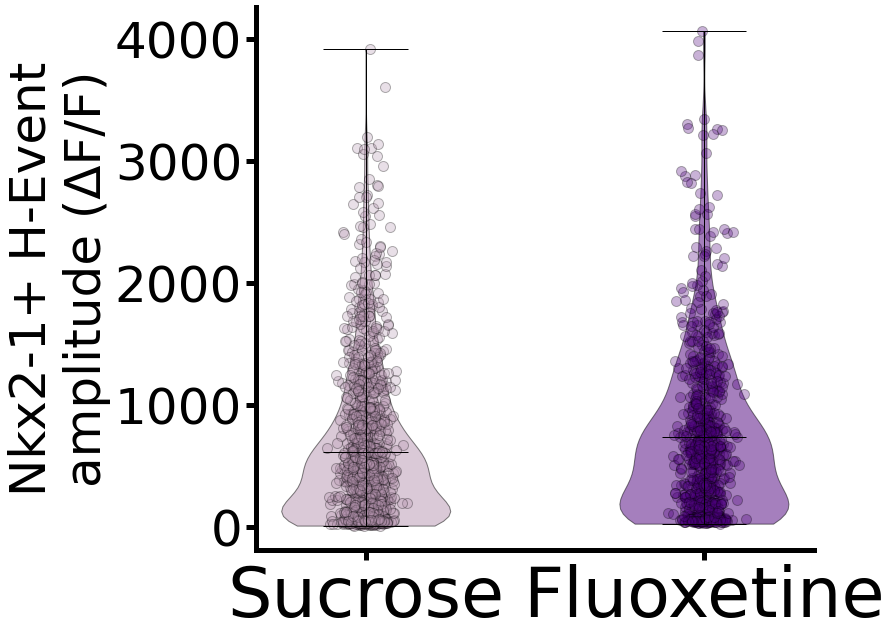

In [112]:
Control = []
SSRI = []


for age in range(7,11):
    df_a = df[df['age']==age]
    for i,row in df_a[df_a['interneuron']=='Nkx2.1'].iterrows():
        try:
            tmp = np.nanmax(row['Interneurons_events_single_neuron_t001']['Peri_H'],2)
            tmp2 = np.nanmax(row['Interneurons_events_single_neuron_t001']['Peri_L'],2)
    
            if row['genotype'] == 'Control':
                Control.append(tmp[:,0])#/tmp[:,1])
            if row['genotype'] == 'SSRI':
                SSRI.append(tmp[:,0])#/tmp[:,1])

        except:
            pass
try:
    Control = (np.hstack(Control)).astype(float)
    SSRI = (np.hstack(SSRI)).astype(float)

except:
    pass



#Violin plot of WT,HET,KO
plt.figure(figsize=(10,10))
#Make 0 nans in WT,HET,KO
Control[Control==0] = np.nan
SSRI[SSRI==0] = np.nan


violin = plt.violinplot([Control[~np.isnan(Control)]],positions=[1],showmeans=True,showextrema=True)
violin2 = plt.violinplot([SSRI],positions=[2],showmeans=True,showextrema=True)


#set all edges black
for partname in ('cbars','cmins','cmaxes','cmeans'):
    vp = violin[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)
    vp = violin2[partname]
    vp.set_edgecolor('black')
    vp.set_linewidth(1)

#color violin plot faces
for pc in violin['bodies']:
    pc.set_facecolor(color1)
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)
for pc in violin2['bodies']:
    pc.set_facecolor(color2)
    pc.set_edgecolor('black')
    pc.set_alpha(0.5)


    
#scatter points on top
plt.scatter(np.ones(Control.shape[0])+np.random.normal(1,0.035,Control.shape[0])-1,Control,color=color1,edgecolors='black',s=100, alpha=0.3)
plt.scatter(np.ones(SSRI.shape[0])+np.random.normal(1,0.035,SSRI.shape[0]),SSRI,color=color2,edgecolors='black',s=100, alpha=0.3)

#Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#Set x and y ticks size
plt.xticks(fontsize=70)
plt.yticks(fontsize=50)
#Set x and y labels
plt.xticks([1,2],['Sucrose','Fluoxetine'],fontsize=70)
plt.ylabel('Nkx2-1+ H-Event\namplitude (ΔF/F)',fontsize=50)

#Make axis thicker
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
#make ticks longer and wider
ax.tick_params(width=5,length=10)

plt.savefig(Save_path + 'Nkx2-1_H_event_amplitude.svg',dpi=300,bbox_inches='tight', format='svg')

#Print lengths of each genotype
print('WT: ' + str(Control.shape[0]))
print('HET: ' + str(SSRI.shape[0]))

#Shapiro test
print(stats.shapiro(Control[~np.isnan(Control)]))
#Krustal wallis
print(stats.mannwhitneyu(Control[~np.isnan(Control)],SSRI[~np.isnan(SSRI)]))


### Whisker responses


In [ ]:
#Iterate thorugh df['Whisker_response_trace_interneurons_single'] and stack all traces in arrays called WT_vip, WT_no_vip...
WT_vip = []
WT_no_vip = []
HET_vip = []
HET_no_vip =[]
KO_vip = []
KO_no_vip = []
mean= np.zeros((3,10))
std = np.zeros((3,10))
geno = ['WT','HET','KO']
multiplier = [0.98,1.02]
WT_trace = np.empty((0,660))
HET_trace = np.empty((0,660))
KO_trace = np.empty((0,660))
for age in range(7,17):
    df_a = df[df['age']==age]
    WT_vip = []
    HET_vip = []
    KO_vip = []
    for i,row in df_a[df_a['interneuron']=='Vip'].iterrows():
        if (row['genotype'] == 'WT') | (row['genotype'] == 'HET') | (row['genotype'] == 'KO'):
            try:
                tmp = np.nanmean(np.max(row['Whisker_response_trace_interneurons_single']['interneurons'][:,:,75:240],2),1)
                tmp2 = np.nanmean(row['Whisker_response_trace_interneurons_single']['interneurons'][:,:,:660],1)
                if row['genotype'] == 'WT':
                    WT_vip.append(tmp)
                    WT_trace = np.vstack([WT_trace,tmp2])
                if row['genotype'] == 'HET':
                    HET_vip.append(tmp)
                    HET_trace = np.vstack([HET_trace,tmp2])
                if row['genotype'] == 'KO':
                    KO_vip.append(tmp)
                    KO_trace = np.vstack([KO_trace,tmp2])
            except:        
                pass
    try:
        WT_vip = (np.hstack(WT_vip)).astype(float)
        HET_vip = (np.hstack(HET_vip)).astype(float)
        KO_vip = (np.hstack(KO_vip)).astype(float)
        _,p = stats.shapiro(WT_vip[~np.isnan(WT_vip)])
        
        if p < 0.05:
            #Prepare data for tukey
            print('At age ' + str(age) + ': ')
            data = np.hstack((WT_vip[~np.isnan(WT_vip)],HET_vip[~np.isnan(HET_vip)],KO_vip[~np.isnan(KO_vip)]))
            gen = np.hstack((np.ones(WT_vip[~np.isnan(WT_vip)].shape[0]),np.ones(HET_vip[~np.isnan(HET_vip)].shape[0])+1,np.ones(KO_vip[~np.isnan(KO_vip)].shape[0])+2))
            #run tukeyt
            print(tukey.MultiComparison(data,gen).tukeyhsd().summary())
            
        elif p>=0.05:
            print('At ' + str(age) + ' is normally distributed')
        mean[0,age-7] = np.nanmean(WT_vip[~np.isnan(WT_vip)])
        mean[1,age-7] = np.nanmean(HET_vip[~np.isnan(HET_vip)])
        mean[2,age-7] = np.nanmean(KO_vip[~np.isnan(KO_vip)])
        std[0,age-7] = np.nanstd(WT_vip[~np.isnan(WT_vip)])/np.sqrt(len(WT_vip[~np.isnan(WT_vip)]))
        std[1,age-7] = np.nanstd(HET_vip[~np.isnan(HET_vip)])/np.sqrt(len(HET_vip[~np.isnan(HET_vip)]))
        std[2,age-7] = np.nanstd(KO_vip[~np.isnan(KO_vip)])/np.sqrt(len(KO_vip[~np.isnan(KO_vip)]))
    except:
        pass

plt.figure(figsize=(7,10))
#Plot with std error bars
plt.errorbar(np.arange(7,16),mean[0,1:],yerr=std[0,1:],color=color1,linewidth=5,capsize=10,capthick=5)
plt.errorbar(np.arange(7,16),mean[1,1:],yerr=std[1,1:],color=color2,linewidth=5,capsize=10,capthick=5)
plt.errorbar(np.arange(7,16),mean[2,1:],yerr=std[2,1:],color=color3,linewidth=5,capsize=10,capthick=5)

#Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#Set x and y ticks size
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
#Set x and y labels
plt.xlabel('Age (days)',fontsize=50)
plt.ylabel('VIP+ Response\namplitude (ΔF/F)',fontsize=50)
#Set x and y ticks
plt.xticks(np.arange(8,17,2))
#Make axis thicker 
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
#make ticks longer and wider
ax.tick_params(width=5,length=10)
leg =plt.legend(['WT','HET','KO'],fontsize=30)
for line in leg.get_lines():
    line.set_linewidth(20)

plt.savefig(Save_path + 'vip_response_amplitude_across_dev.svg',dpi=300,bbox_inches='tight', format='svg')

At age 7: 
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2  meandiff p-adj   lower    upper   reject
-------------------------------------------------------
   1.0    2.0 -126.2569 0.001 -177.0325 -75.4814   True
-------------------------------------------------------
At age 8: 
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2  meandiff p-adj   lower    upper   reject
-------------------------------------------------------
   1.0    2.0 -102.8222 0.001 -155.2836 -50.3609   True
-------------------------------------------------------
At age 9: 
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj   lower     upper   reject
--------------------------------------------------------
   1.0    2.0 -155.2038 0.001 -197.7657 -112.6419   True
--------------------------------------------------------
At age 10: 
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper   reject
--

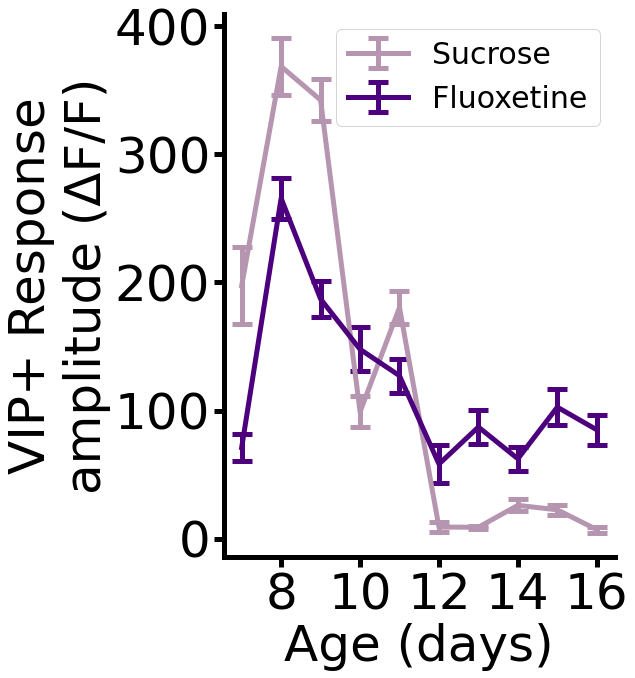

In [236]:
#Same as previous cell but with Control and SSRI instead of WT,HET,KO
Control_vip = [] 
SSRI_vip = []
mean= np.zeros((2,10))
std = np.zeros((2,10))
geno = ['Control','SSRI']
multiplier = [0.98,1.02]
Control_trace = np.empty((0,660))
SSRI_trace = np.empty((0,660))

for age in range(7,17):
    df_a = df[df['age']==age]
    Control_vip = []
    SSRI_vip = []
    for i,row in df_a[df_a['interneuron']=='Vip'].iterrows():
        if (row['genotype'] == 'Control') | (row['genotype'] == 'SSRI'):
            try:
                tmp = np.nanmean(np.max(row['Whisker_response_trace_interneurons_single']['interneurons'][:,:,75:240],2),1)
                tmp2 = np.nanmean(row['Whisker_response_trace_interneurons_single']['interneurons'][:,:,:660],1)
                if row['genotype'] == 'Control':
                    Control_vip.append(tmp)
                    Control_trace = np.vstack([Control_trace,tmp2])
                if row['genotype'] == 'SSRI':
                    SSRI_vip.append(tmp)
                    SSRI_trace = np.vstack([SSRI_trace,tmp2])
            except:        
                pass
    try:
        Control_vip = (np.hstack(Control_vip)).astype(float)
        SSRI_vip = (np.hstack(SSRI_vip)).astype(float)
        _,p = stats.shapiro(Control_vip[~np.isnan(Control_vip)])
        
        if p < 0.05:
            #Prepare data for tukey
            print('At age ' + str(age) + ': ')
            data = np.hstack((Control_vip[~np.isnan(Control_vip)],SSRI_vip[~np.isnan(SSRI_vip)]))
            gen = np.hstack((np.ones(Control_vip[~np.isnan(Control_vip)].shape[0]),np.ones(SSRI_vip[~np.isnan(SSRI_vip)].shape[0])+1))
            #run tukeyt
            print(tukey.MultiComparison(data,gen).tukeyhsd().summary())
            
        elif p>=0.05:
            print('At ' + str(age) + ' is normally distributed')
        mean[0,age-7] = np.nanmean(Control_vip[~np.isnan(Control_vip)])
        mean[1,age-7] = np.nanmean(SSRI_vip[~np.isnan(SSRI_vip)])
        std[0,age-7] = np.nanstd(Control_vip[~np.isnan(Control_vip)])/np.sqrt(len(Control_vip[~np.isnan(Control_vip)]))
        std[1,age-7] = np.nanstd(SSRI_vip[~np.isnan(SSRI_vip)])/np.sqrt(len(SSRI_vip[~np.isnan(SSRI_vip)]))
    except:
        pass

plt.figure(figsize=(7,10))
#Plot with std error bars
plt.errorbar(np.arange(7,16.1),mean[0,:],yerr=std[0,:],color=color1,linewidth=5,capsize=10,capthick=5)
plt.errorbar(np.arange(7,16.1),mean[1,:],yerr=std[1,:],color=color2,linewidth=5,capsize=10,capthick=5)

#Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#Set x and y ticks size
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
#Set x and y labels
plt.xlabel('Age (days)',fontsize=50)
plt.ylabel('VIP+ Response\namplitude (ΔF/F)',fontsize=50)
#Set x and y ticks
plt.xticks(np.arange(8,17,2))
#Make axis thicker
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
#make ticks longer and wider
ax.tick_params(width=5,length=10)
leg =plt.legend(['Sucrose','Fluoxetine'],fontsize=30)
for line in leg.get_lines():
    line.set_linewidth(20)

plt.savefig(Save_path + 'Control_ssri_vip_response_amplitude_across_dev.svg',dpi=300,bbox_inches='tight', format='svg')

At age 7: 
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower   upper   reject
----------------------------------------------------
   1.0    2.0  84.0945 0.0316 7.4635 160.7255   True
----------------------------------------------------
At age 8: 
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj    lower   upper  reject
-----------------------------------------------------
   1.0    2.0 -51.5791 0.1243 -117.4023 14.244  False
-----------------------------------------------------
At age 9: 
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower   upper   reject
----------------------------------------------------
   1.0    2.0 152.8645 0.001 96.6615 209.0676   True
----------------------------------------------------
At age 10: 
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper  reject
---------------------------------------------

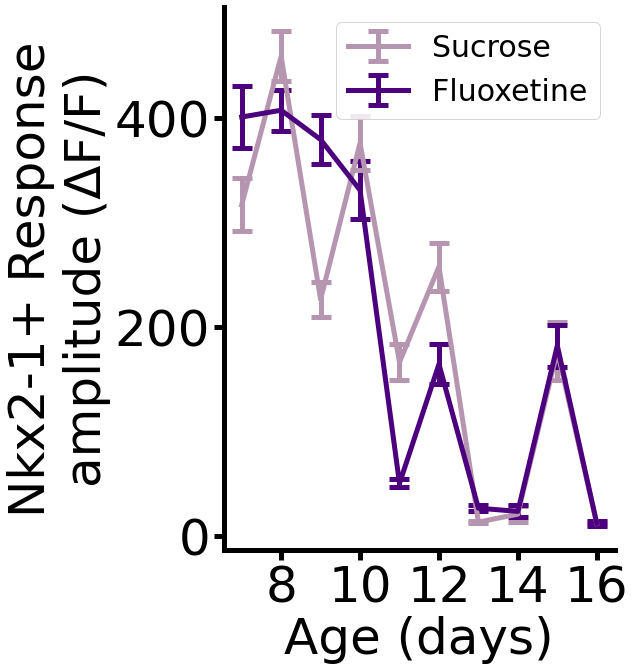

In [238]:
#Same as previous cell but with Control and SSRI instead of WT,HET,KO
Control_vip = [] 
SSRI_vip = []
mean= np.zeros((2,10))
std = np.zeros((2,10))
geno = ['Control','SSRI']
multiplier = [0.98,1.02]
Control_trace = np.empty((0,660))
SSRI_trace = np.empty((0,660))

for age in range(7,17):
    df_a = df[df['age']==age]
    Control_vip = []
    SSRI_vip = []
    for i,row in df_a[df_a['interneuron']=='Nkx2.1'].iterrows():
        if (row['genotype'] == 'Control') | (row['genotype'] == 'SSRI'):
            try:
                tmp = np.nanmean(np.nanmax(row['Whisker_response_trace_interneurons_single']['interneurons'][:,:,75:660],2),1)
                tmp2 = np.nanmean(row['Whisker_response_trace_interneurons_single']['interneurons'][:,:,:660],1)
                if row['genotype'] == 'Control':
                    Control_vip.append(tmp)
                    Control_trace = np.vstack([Control_trace,tmp2])
                if row['genotype'] == 'SSRI':
                    SSRI_vip.append(tmp)
                    SSRI_trace = np.vstack([SSRI_trace,tmp2])
            except:        
                pass
    try:
        Control_vip = (np.hstack(Control_vip)).astype(float)
        SSRI_vip = (np.hstack(SSRI_vip)).astype(float)
        _,p = stats.shapiro(Control_vip[~np.isnan(Control_vip)])
        
        if p < 0.05:
            #Prepare data for tukey
            print('At age ' + str(age) + ': ')
            data = np.hstack((Control_vip[~np.isnan(Control_vip)],SSRI_vip[~np.isnan(SSRI_vip)]))
            gen = np.hstack((np.ones(Control_vip[~np.isnan(Control_vip)].shape[0]),np.ones(SSRI_vip[~np.isnan(SSRI_vip)].shape[0])+1))
            #run tukeyt
            print(tukey.MultiComparison(data,gen).tukeyhsd().summary())
            
        elif p>=0.05:
            print('At ' + str(age) + ' is normally distributed')
        mean[0,age-7] = np.nanmean(Control_vip[~np.isnan(Control_vip)])
        mean[1,age-7] = np.nanmean(SSRI_vip[~np.isnan(SSRI_vip)])
        std[0,age-7] = np.nanstd(Control_vip[~np.isnan(Control_vip)])/np.sqrt(len(Control_vip[~np.isnan(Control_vip)]))
        std[1,age-7] = np.nanstd(SSRI_vip[~np.isnan(SSRI_vip)])/np.sqrt(len(SSRI_vip[~np.isnan(SSRI_vip)]))
    except:
        pass

plt.figure(figsize=(7,10))
#Plot with std error bars
plt.errorbar(np.arange(7,16.1),mean[0,:],yerr=std[0,:],color=color1,linewidth=5,capsize=10,capthick=5)
plt.errorbar(np.arange(7,16.1),mean[1,:],yerr=std[1,:],color=color2,linewidth=5,capsize=10,capthick=5)

#Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#Set x and y ticks size
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
#Set x and y labels
plt.xlabel('Age (days)',fontsize=50)
plt.ylabel('Nkx2-1+ Response\namplitude (ΔF/F)',fontsize=50)
#Set x and y ticks
plt.xticks(np.arange(8,17,2))
#Make axis thicker
ax.spines['left'].set_linewidth(5)
ax.spines['bottom'].set_linewidth(5)
#make ticks longer and wider
ax.tick_params(width=5,length=10)
leg =plt.legend(['Sucrose','Fluoxetine'],fontsize=30)
for line in leg.get_lines():
    line.set_linewidth(20)

plt.savefig(Save_path + 'Control_ssri_nkx2-1_response_amplitude_across_dev.svg',dpi=300,bbox_inches='tight', format='svg')

# Control - WT

## Load data

In [ ]:
Path_df = '//qnap-amp001.dpag.ox.ac.uk/gsantero/Analysis/Data_frames/With_data/'
file_name = '2023_08_08_df_data'

#import 2023_03_18_df_cumsum as df_cumsum using pickle
with open(Path_df + file_name,'rb') as handle:
    df = pickle.load(handle)

df['interneuron'] = df['interneuron'].replace('NKx2.1','Nkx2.1')
df['genotype'] = df['genotype'].replace('KO ','KO')
df['genotype'] = df['genotype'].replace('HET ','HET')
df['genotype'] = df['genotype'].replace('WT ','WT')
df['genotype'] = df['genotype'].replace('WT?','WT')

#extract_to_separate_coloumn number of neurons to separate coloumn
df = PdA.extract_to_separate_coloumn(df,'Number_of_neurons',0,'Neurons')
df = PdA.extract_to_separate_coloumn(df, 'Whisker_responses',-3,'Proportion_resp')
for n in range(0,10):
    df = PdA.extract_to_separate_coloumn(df, 'Whisker_responses',n,'Resp' + str((n+1)*10) + '%')
for n in range(0,10):
    df = PdA.extract_to_separate_coloumn(df, 'Airpuff_responses',n,'AResp' + str((n+1)*10) + '%')
df = PdA.extract_to_separate_coloumn(df, 'Whisker_responses',-3,'Whisker_responsive')
df = PdA.extract_to_separate_coloumn(df, 'Airpuff_responses',-3,'Airpuff_responsive')
df = PdA.extract_to_separate_coloumn(df,'Correlations',0,'Mean_correlation')


#Remove rows with less than 500 neuorns and print how many where removed
print('Number of rows removed: ' + str(len(df[df['Neurons'] < 500])))
df = df[df['Neurons'] >= 500]

#remove runt 351 (died at P10 very underweighted)
df = df[df['animal'] != 'GOS351']
df.head(n=10)

#remove GOS464 ONWARDS (WT dams)
df = df[df['animal'] != 'GOS466']
df = df[df['animal'] != 'GOS470']
df = df[df['animal'] != 'GOS471']


Number of rows removed: 53


## Mean correlation

In [4]:
color1 = '#b695b0'
color2 = '#0cbccc'



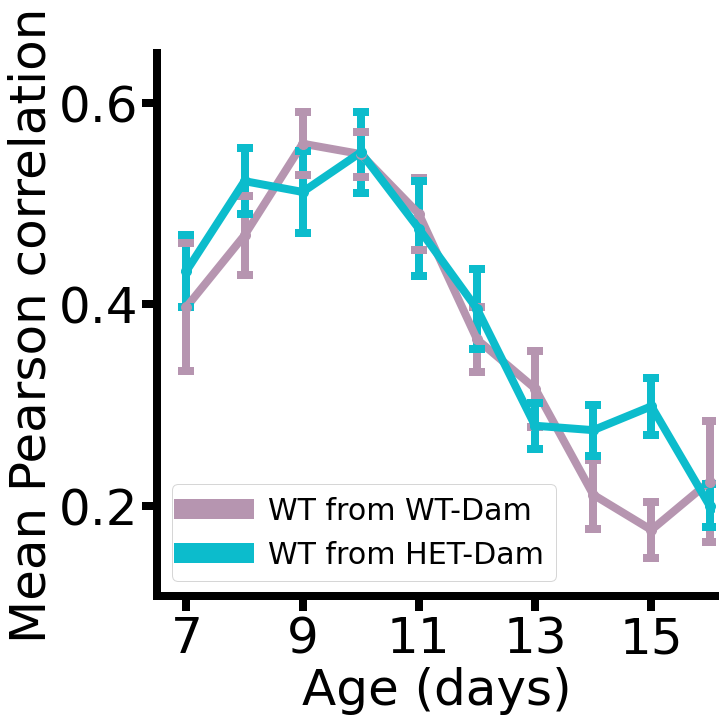

In [166]:
# Plot mean correlation for Control and WT
plt.figure(figsize=(10,10))
PdA.developmental_plot_errorbars(df,parameter='Mean_correlation',genotype=['Control','WT'],color=[color1,color2], y_label = 'Mean Pearson correlation',fontsize=50)
plt.xlim([-0.5,9.1])
leg = plt.legend(['WT from WT-Dam','WT from HET-Dam'],fontsize=30)
for leg in leg.legendHandles:
    leg.set_linewidth(20)
    plt.yticks(np.arange(0.2,0.61,0.2),fontsize=50)
    plt.ylim(0.11,0.65)
    plt.xticks(fontsize=50)

plt.savefig(Save_path + 'Maternal_fenotype_Mean_correlation.svg',dpi=300,bbox_inches='tight',format='svg')
    


In [4]:
color1 = '#0cbccc'
color2 = '#107acc'
color3 = '#15297c'

C:\Users\gabrielos\AppData\Local\Temp\ipykernel_104936\3558038395.py:7: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for leg in leg.legendHandles:


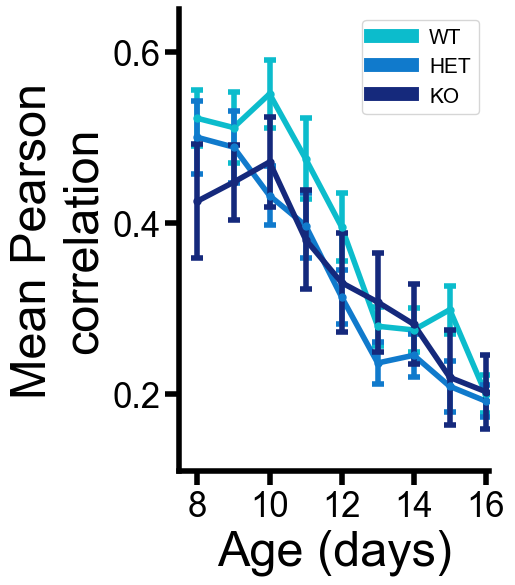

In [34]:
# Plot mean correlation for Control and WT
plt.rcParams['font.sans-serif'] = 'Arial'
plt.figure(figsize=(4,6))
PdA.developmental_plot_errorbars(df[df['age']>7],parameter='Mean_correlation',genotype=['WT','HET','KO'],color=[color1,color2,color3], y_label = 'Mean Pearson\ncorrelation',fontsize=50, LW = 4)
plt.xlim([0.5,9.1])
leg = plt.legend(['WT','HET','KO'],fontsize=15)
for leg in leg.legendHandles:
    leg.set_linewidth(10)
plt.yticks(np.arange(0.2,0.61,0.2),fontsize=25)
plt.ylim(0.11,0.65)
plt.xticks(np.arange(1,9.1,2),np.arange(8,16.1,2).astype(int),fontsize=25)
#Chnage line thickness
ax = plt.gca()
ax.spines['left'].set_linewidth(4)
ax.spines['bottom'].set_linewidth(4)
#make ticks longer and wider
ax.tick_params(width=4,length=10)

plt.xlabel('Age (days)',fontsize=35)
plt.ylabel('Mean Pearson\ncorrelation',fontsize=35)
#Set arial font
plt.savefig(Save_path + 'SERTKO_Mean_correlation.svg',dpi=300,bbox_inches='tight',format='svg')


#two way anova
#CaaN.stating(df[(df['age']>7)&(df['age']<17)],'Mean_correlation',['WT','HET','KO'], alpha=0.05)


In [137]:
# No significant difference between maternal WT and HET
#Shapiro
print(stats.shapiro(df[df['genotype']=='Control']['Mean_correlation']))
#Krustal wallis
df_tmp = df.copy()
#Remove mean_correlation nones
df_tmp = df_tmp[df_tmp['Mean_correlation'].notna()]
#age <17
df_tmp = df_tmp[df_tmp['age']<17]
CaaN.stating(df_tmp,parameter='Mean_correlation',genotypes=['Control','WT'])

ShapiroResult(statistic=0.9634661078453064, pvalue=0.007158408872783184)
Two way ANOVA results:
                      sum_sq     df          F        PR(>F)
C(age)              3.322873    9.0  25.841858  5.921531e-29
C(genotype)         0.015983    1.0   1.118724  2.915019e-01
C(age):C(genotype)  0.126423    9.0   0.983184  4.552021e-01
Residual            2.786006  195.0        NaN           NaN
Shapiro p-val:0.0012871490325778723


c:\Users\gabrielos\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 8
  warnings.warn('covariance of constraints does not have full '
c:\Users\gabrielos\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 8
  warnings.warn('covariance of constraints does not have full '
c:\Users\gabrielos\anaconda3\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 8
  warnings.warn('covariance of constraints does not have full '


Permutation test results:
(0.0, 0.287, 0.454)


## Event analysis

([<matplotlib.axis.XTick at 0x21e89104b50>,
 [Text(1, 0, 'WT from\nWT-Dam'), Text(2, 0, 'WT from\nHET-Dam')])

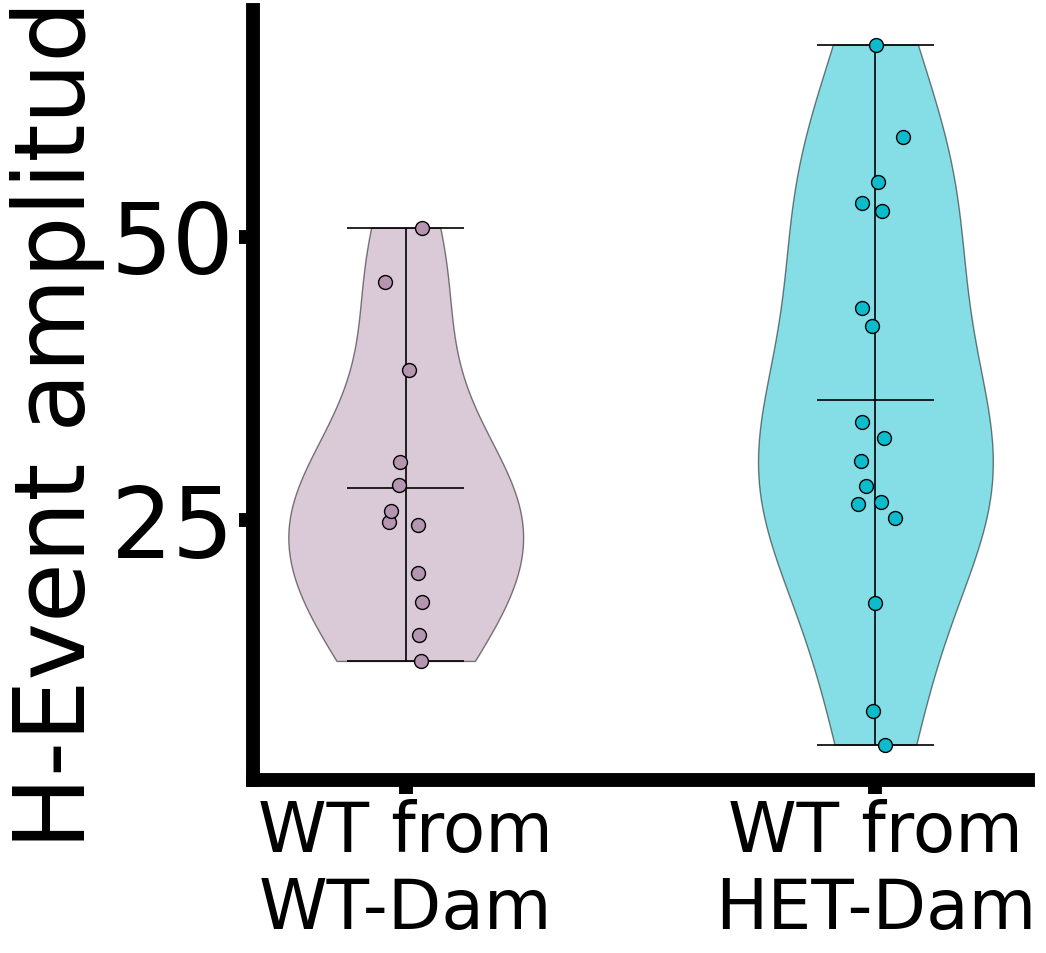

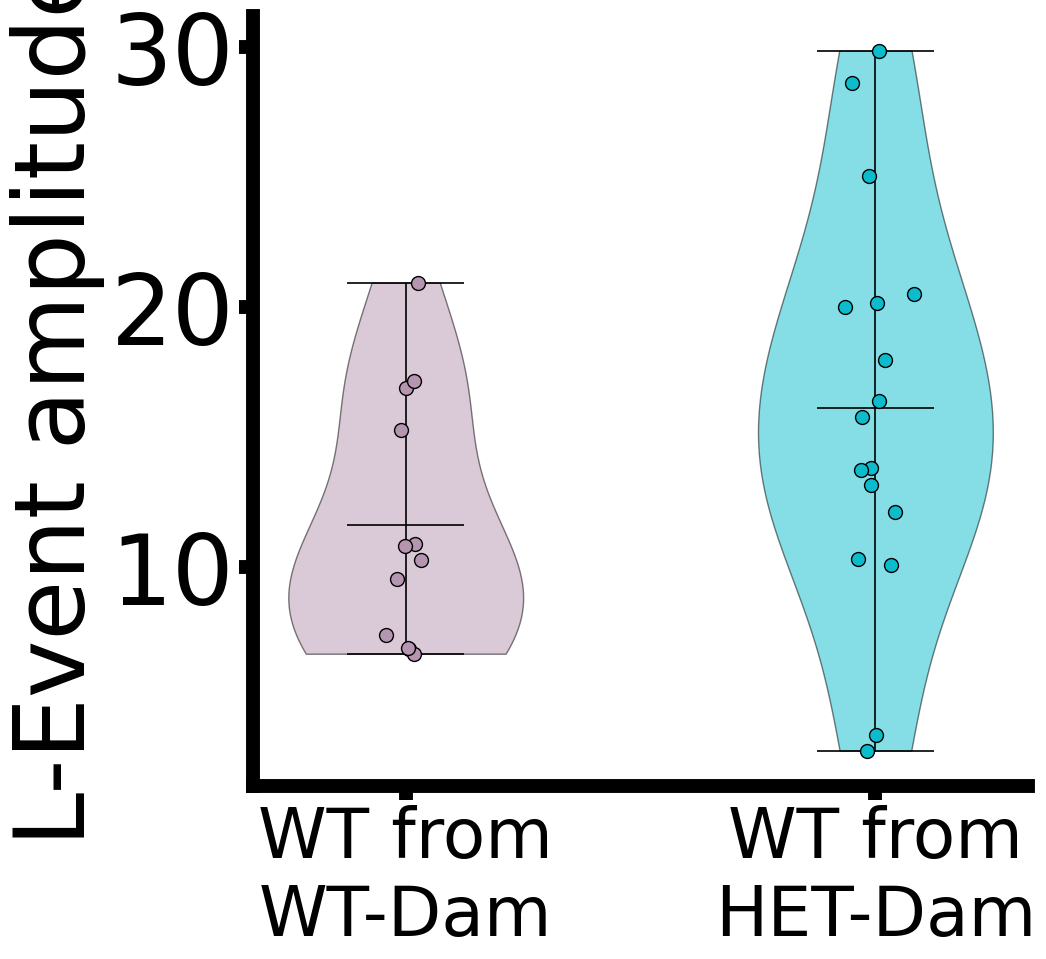

In [52]:
#Number of events violin plot
plt.figure(figsize=(10,10))
PdA.violin_plot(df[df['age']<11],parameter='H_Event_max' , genotypes=['Control','WT'], y_label = 'H-Event amplitude', color = [color1,color2],title = None, fontsize = 70)
plt.xticks([1,2],['WT from\nWT-Dam','WT from\nHET-Dam'],fontsize=50)
plt.savefig(Save_path + 'Maternal_fenotype_H_event_max_violin.svg', dpi=300, bbox_inches='tight')
plt.figure(figsize=(10,10))
PdA.violin_plot(df[df['age']<11],parameter='L_Event_max' , genotypes=['Control', 'WT'], y_label = 'L-Event amplitude', color = [color1,color2],title = None, fontsize = 70)
plt.xticks([1,2],['WT from\nWT-Dam','WT from\nHET-Dam'],fontsize=50)
plt.savefig(Save_path + 'Maternal_fenotype_L_event_max_violin.svg', dpi=300, bbox_inches='tight')

In [54]:
# Number of H events stats: Significant difference between control and ssri

df_tmp = df[df['age']<11]
#Select only control and ssri
df_tmp = df_tmp[df_tmp['genotype'].isin(['Control','WT'])]
#Make control control 0 and ssri 1
df_tmp['genotype'] = df_tmp['genotype'].replace('Control',0)
df_tmp['genotype'] = df_tmp['genotype'].replace('WT',1)
#Average across ages for the same animal
df_tmp = df_tmp.groupby(['animal']).mean().reset_index()
#Perform shapiro
print(stats.shapiro(df_tmp[df_tmp['genotype']==0]['H_Event_max']))
#Perform mann whitney u test in control and ssri
print(stats.ttest_ind(df_tmp[df_tmp['genotype']==0]['H_Event_max'],df_tmp[df_tmp['genotype']==1]['H_Event_max']))

ShapiroResult(statistic=0.9290245771408081, pvalue=0.3698880076408386)
Ttest_indResult(statistic=-1.325745777918302, pvalue=0.19603196159923914)


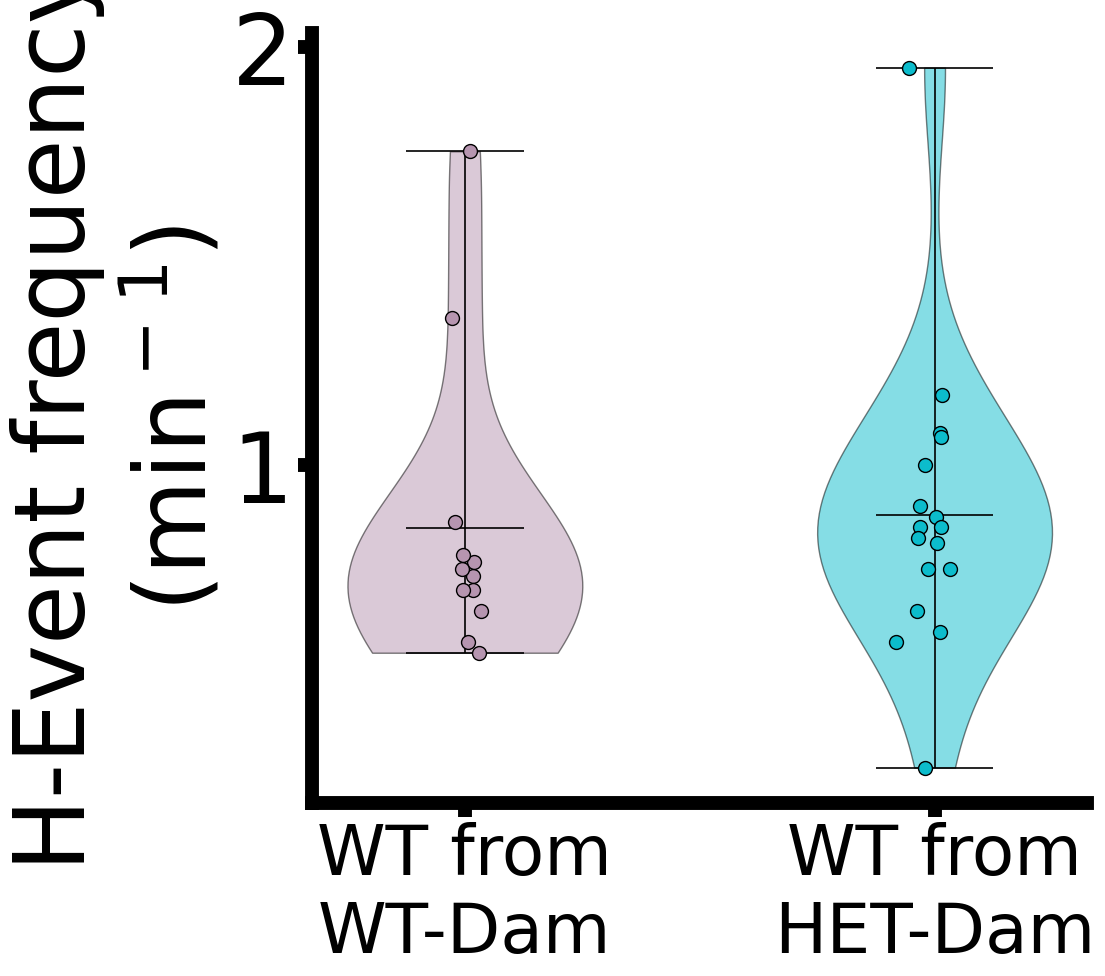

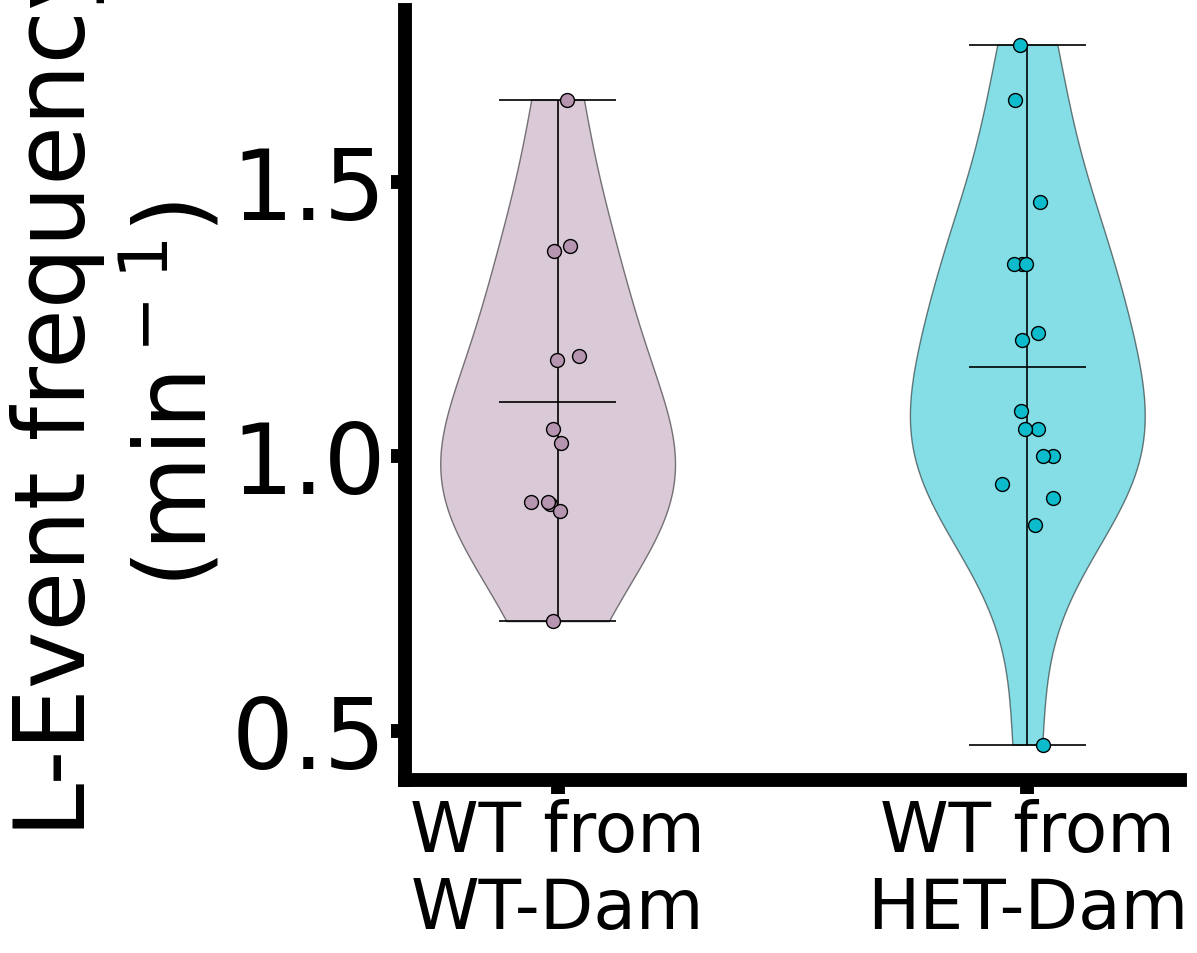

In [51]:
#Number of events violin plot
plt.figure(figsize=(10,10))
PdA.violin_plot(df[df['age']<11],parameter='H_events' , genotypes=['Control','WT'], y_label = 'H-Event frequency\n(min$^-$$^1$)', color = [color1,color2],title = None, fontsize = 70)
# x axis label 'Sucrose' and 'Fluoxetine'
plt.xticks([1,2],['WT from\nWT-Dam','WT from\nHET-Dam'],fontsize=50)


plt.savefig(Save_path + 'Maternal_fenotype_H_events_violin.svg', dpi=300, bbox_inches='tight')
plt.figure(figsize=(10,10))
PdA.violin_plot(df[df['age']<11],parameter='L_events' , genotypes=['Control','WT'], y_label = 'L-Event frequency\n(min$^-$$^1$)', color = [color1,color2],title = None, fontsize = 70)
plt.xticks([1,2],['WT from\nWT-Dam','WT from\nHET-Dam'],fontsize=50)

plt.savefig(Save_path + 'Maternal_fenotype_L_events_violin.svg', dpi=300, bbox_inches='tight')

In [53]:
# Number of H events stats: Significant difference between control and ssri

df_tmp = df[df['age']<11]
#Select only control and ssri
df_tmp = df_tmp[df_tmp['genotype'].isin(['Control','WT'])]
#Make control control 0 and ssri 1
df_tmp['genotype'] = df_tmp['genotype'].replace('Control',0)
df_tmp['genotype'] = df_tmp['genotype'].replace('WT',1)
#Average across ages for the same animal
df_tmp = df_tmp.groupby(['animal']).mean().reset_index()
#Perform shapiro
print(stats.shapiro(df_tmp[df_tmp['genotype']==0]['H_events']))
#Perform mann whitney u test in control and ssri
print(stats.mannwhitneyu(df_tmp[df_tmp['genotype']==0]['H_events'],df_tmp[df_tmp['genotype']==1]['H_events']))

ShapiroResult(statistic=0.7201181650161743, pvalue=0.001325802644714713)
MannwhitneyuResult(statistic=77.0, pvalue=0.27756098774166027)


## Whisker response

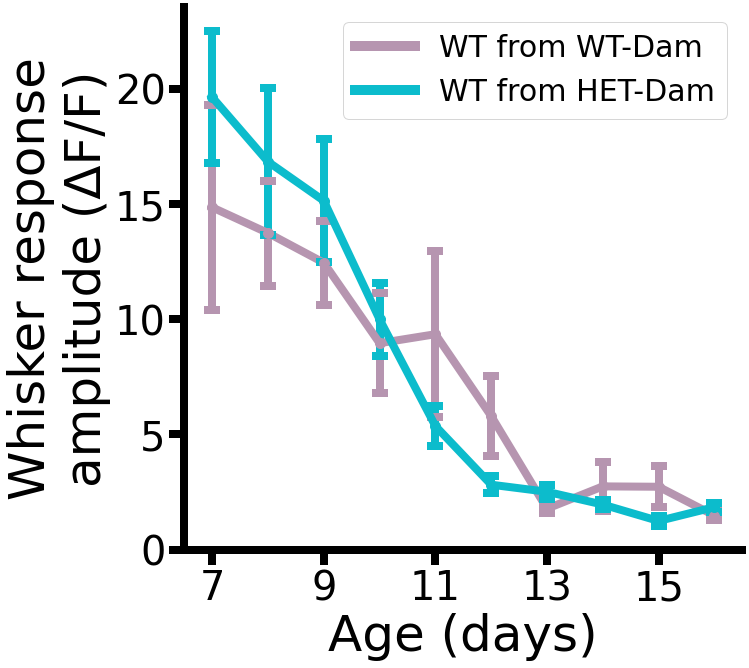

In [163]:
#df = df[df['Neurons']>300]
#Calculate AUC in the cropped traces and store it in a new column called 'Whisker_response_AUC_cropped'
df['Whisker_response_trace_cropped'] = None
df['Whisker_response_AUC_cropped'] = np.nan
for i, row in df.iterrows():
 #if row['Whisker_responsive']>=0.01: 
    #try:
    #tmp =  row['Whisker_response_trace'][:660]
    #If it is np.nan, remove this row from df_tmp
    #if np.isnan(tmp).any():
     #   df_tmp = df.drop(i)
   # else:
  if row['Whisker_responsive']>=0.00:
    try:
      tmp =  row['Whisker_response_trace'][:660]
      df.at[i,'Whisker_response_trace_cropped'] = tmp
      #if it is nan or none, remove it
      df.at[i,'Whisker_response_AUC_cropped'] = np.max(tmp[60:])
    except:
      df.at[i,'Whisker_response_AUC_cropped'] = np.nan
  else:
    df.at[i,'Whisker_response_AUC_cropped'] = np.nan

#Plot as a function of age
plt.figure(figsize=(10,10))
PdA.developmental_plot_errorbars(df[df['age']<17],'Whisker_response_AUC_cropped', y_label='Whisker response\namplitude (ΔF/F)',genotype=['Control','WT'],color=[color1,color2],fontsize=50)
# Make ticks font bigger
plt.xticks(fontsize=40)
plt.yticks(np.arange(0,21,5),fontsize=40)
leg = plt.legend(['WT from WT-Dam','WT from HET-Dam'],fontsize=30)
for line in leg.get_lines():
    line.set_linewidth(10)
plt.xlim([-0.5, 9.5])
#Plot a cyan asterisc on top of P7
#plt.scatter(0,df[df['age']==7]['Whisker_response_AUC_cropped'].max()*0.7,marker='*',s=1000,c='c')
#Plot a magenta asterisc on top of P12
#plt.scatter(4,df[df['age']==12]['Whisker_response_AUC_cropped'].max()*0.7,marker='*',s=1000,c='m')
#change y scale
#plt.yscale('log')
#save figure
plt.savefig(Save_path + 'Maternal_fenotype_across_dev_Whisker_response_amplitude.svg', dpi=300, bbox_inches='tight')

In [162]:
#Non significant maternal phenotype
CaaN.stating(df[(df['age']<17)],parameter='Whisker_response_AUC_cropped',genotypes=['Control','WT'])
#Even assuming interaction, which there isn't
CaaN.stating(df[(df['age']>10)&(df['age']<17)],parameter='Whisker_response_AUC_cropped',genotypes=['Control','WT'])

Two way ANOVA results:
                         sum_sq     df          F        PR(>F)
C(age)              6050.795614    9.0  16.248337  6.115273e-19
C(genotype)            4.337518    1.0   0.104829  7.465177e-01
C(age):C(genotype)   308.995550    9.0   0.829753  5.896211e-01
Residual            6868.614380  166.0        NaN           NaN
Shapiro p-val:1.0
Two way ANOVA results:
                         sum_sq    df         F    PR(>F)
C(age)               468.962505   5.0  4.996912  0.000409
C(genotype)           56.879631   1.0  3.030333  0.084892
C(age):C(genotype)    81.141238   5.0  0.864580  0.507892
Residual            1820.699157  97.0       NaN       NaN
Shapiro p-val:1.0


T-test: Ttest_indResult(statistic=-1.202118686386988, pvalue=0.24058088240342967)


C:\Users\gabrielos\AppData\Local\Temp\ipykernel_67520\912218138.py:13: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for leg in leg.legendHandles:


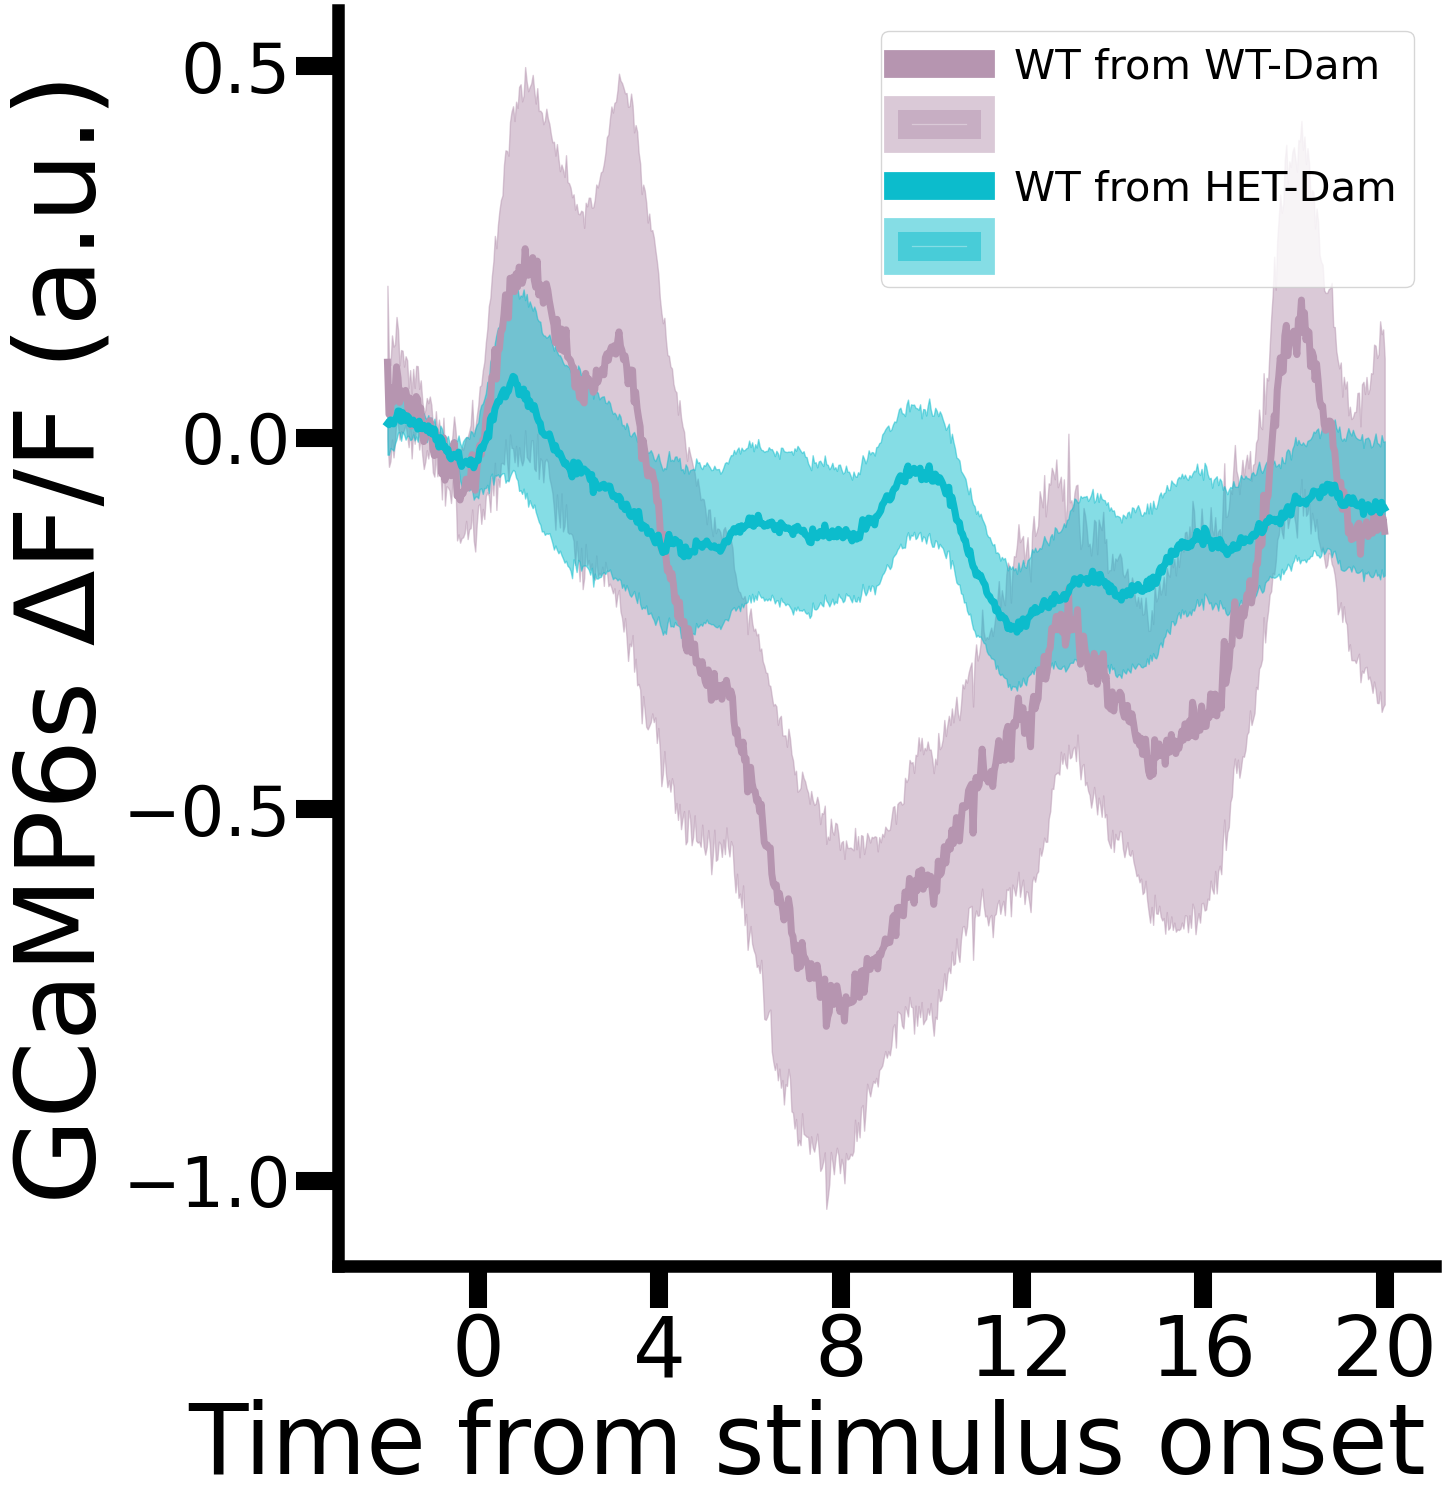

In [49]:
#14-16 response
df['Whisker_response_trace_cropped'] = None
for i, row in df.iterrows():

        try:
            df.at[i,'Whisker_response_trace_cropped'] = row['Whisker_response_trace'][:660]
        except:
            pass
plt.figure(figsize=(15,15))
PdA.Response(df,parameter='Whisker_response_trace_cropped', length = 660, genotypes=['Control','WT'], ages=[11,12,13], color = [color1,color2],title = None,sp_row=1,sp_colomn=1,sp_number=1,stat = np.nanmean)

leg = plt.legend(['WT from WT-Dam','','WT from HET-Dam',''],fontsize=30)
for leg in leg.legendHandles:
    leg.set_linewidth(20)
plt.xlabel('Time from stimulus onset (s)',fontsize=70)
#replace x ticks at time 0,60,120,.. 660 with -2,0,2,.. 20
plt.xticks(np.linspace(0,600,6),np.linspace(0,20,6).astype(int),fontsize=60)
plt.yticks(np.arange(-1,0.6,0.5),fontsize=50)
plt.ylabel('GCaMP6s ΔF/F (a.u.)',fontsize=80)

#save figure
plt.savefig(Save_path + 'Whisker_response_22s_p17-10.svg',dpi=300,bbox_inches='tight',format='svg')


In [48]:
Save_path = '//qnap-amp001.dpag.ox.ac.uk/gsantero/Analysis/Paper_figures/Rebuttals/'

c:\Users\gabrielos\anaconda3\lib\site-packages\pandas\core\missing.py:94: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= arr == x


ShapiroResult(statistic=0.8253968954086304, pvalue=0.01848457381129265)
Ttest_indResult(statistic=-1.0440171364330377, pvalue=0.30646814664116906)
MannwhitneyuResult(statistic=84.0, pvalue=0.7884125897107042)


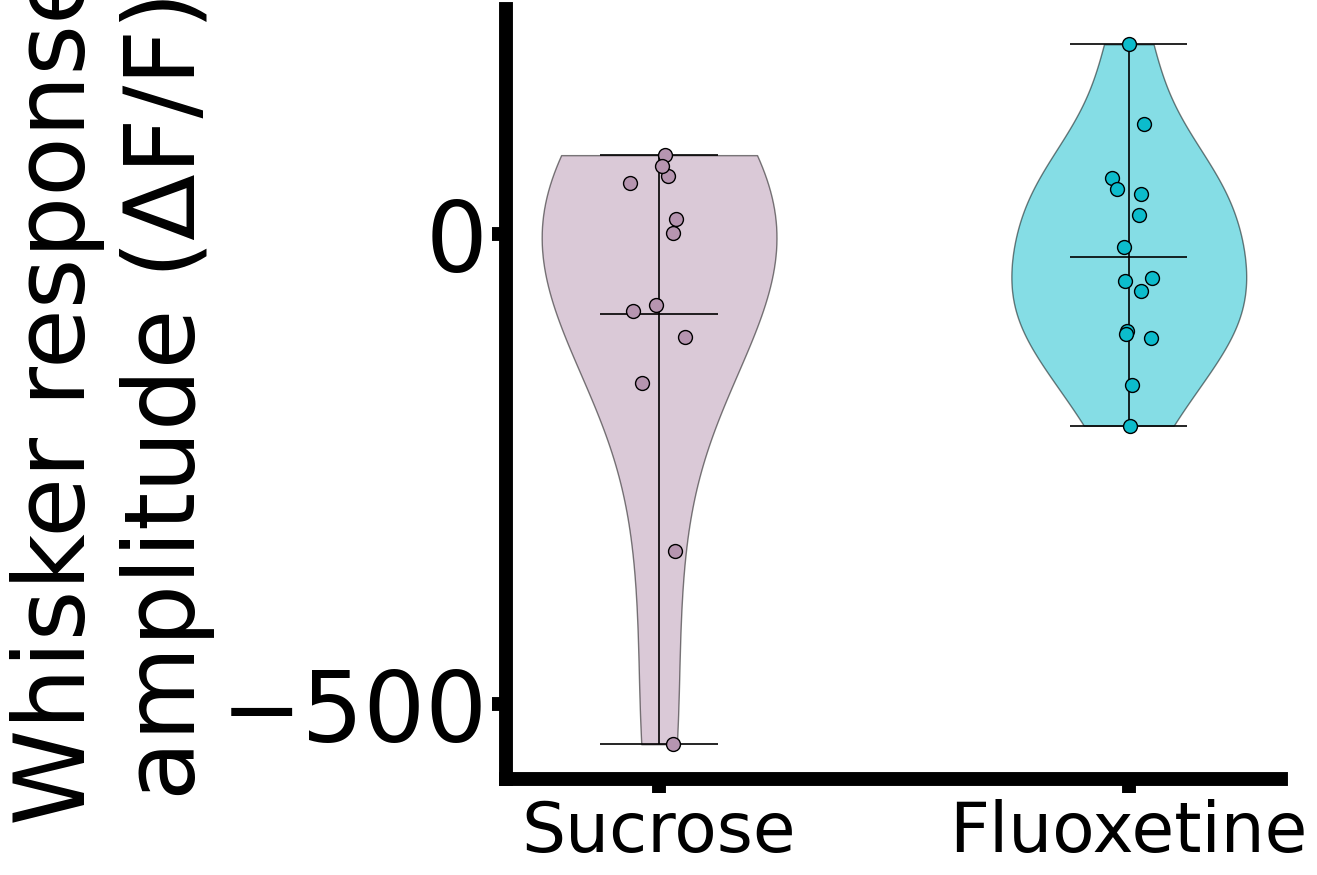

In [60]:
#df = df[df['Neurons']>300]
#Calculate AUC in the cropped traces and store it in a new column called 'Whisker_response_AUC_cropped'
df['Whisker_response_trace_cropped'] = None
df['Whisker_response_AUC_cropped'] = np.nan
for i, row in df.iterrows():
 #if row['Whisker_responsive']>=0.01: 
    #try:
    #tmp =  row['Whisker_response_trace'][:660]
    #If it is np.nan, remove this row from df_tmp
    #if np.isnan(tmp).any():
     #   df_tmp = df.drop(i)
   # else:
  if row['Whisker_responsive']>=0.00:
    try:
      tmp =  row['Whisker_response_trace'][:660]
      tmp = tmp - np.nanmean(tmp[0:60])
      df.at[i,'Whisker_response_trace_cropped'] = tmp
      #if it is nan or none, remove it
      df.at[i,'Whisker_response_AUC_cropped'] = np.trapz(tmp[60:360])
    except:
      df.at[i,'Whisker_response_AUC_cropped'] = np.nan
  else:
    df.at[i,'Whisker_response_AUC_cropped'] = np.nan
#7-10 response
df_control_SSRI = df[(df['genotype']=='Control') | (df['genotype']=='WT')]
#Replace control for 0 and ssri for 1
df_control_SSRI = df_control_SSRI.replace('Control',0)
df_control_SSRI = df_control_SSRI.replace('WT',1)
#select age <11
df_control_SSRI = df_control_SSRI[(df_control_SSRI['age']>10) & (df_control_SSRI['age']<14)]

#Mean across ages
df_control_SSRI = df_control_SSRI.groupby(['animal','genotype']).mean().reset_index()
#Remove nans in whisker response AUC
df_control_SSRI = df_control_SSRI[df_control_SSRI['Whisker_response_AUC_cropped'].notnull()]
#shapiro
print(stats.shapiro(df_control_SSRI[df_control_SSRI['genotype']==0]['Whisker_response_AUC_cropped']))
#remove nans

#Run t test
print(stats.ttest_ind(df_control_SSRI[df_control_SSRI['genotype']==0]['Whisker_response_AUC_cropped'],df_control_SSRI[df_control_SSRI['genotype']==1]['Whisker_response_AUC_cropped']))
#mann whitney u test
print(stats.mannwhitneyu(df_control_SSRI[df_control_SSRI['genotype']==0]['Whisker_response_AUC_cropped'],df_control_SSRI[df_control_SSRI['genotype']==1]['Whisker_response_AUC_cropped']))
#Plot violin plot
plt.figure(figsize=(10,10))
PdA.violin_plot(df[(df['age']>10) & (df['age']<14)],parameter='Whisker_response_AUC_cropped' , genotypes=['Control','WT'], y_label = 'Whisker response\namplitude (ΔF/F)', color = [color1,color2],title = None, fontsize = 70)

#set  xticks as 'Sucrose' and 'Fluoxetine'
#plt.yticks(np.arange(0,21,10),fontsize=50)
plt.xticks([1,2],['Sucrose','Fluoxetine'],fontsize=50)
plt.savefig(Save_path + 'P7_10_Whisker_response_AUC_violin.svg', dpi=300, bbox_inches='tight')

c:\Users\gabrielos\SerotoninBeyond\DPhil_2\Notebooks\utils\Pandas_analysis.py:682: RuntimeWarning: Mean of empty slice
  baseline = np.nanmean(globals()[g][:,:60],axis=1)
c:\Users\gabrielos\SerotoninBeyond\DPhil_2\Notebooks\utils\Pandas_analysis.py:691: RuntimeWarning: Mean of empty slice
  globals()[g] = stat(globals()[g][:,60:],axis=1)
C:\Users\gabrielos\AppData\Local\Temp\ipykernel_67520\3200089064.py:13: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for leg in leg.legendHandles:


T-test: Ttest_indResult(statistic=-0.08155778685336387, pvalue=0.9356229755285627)


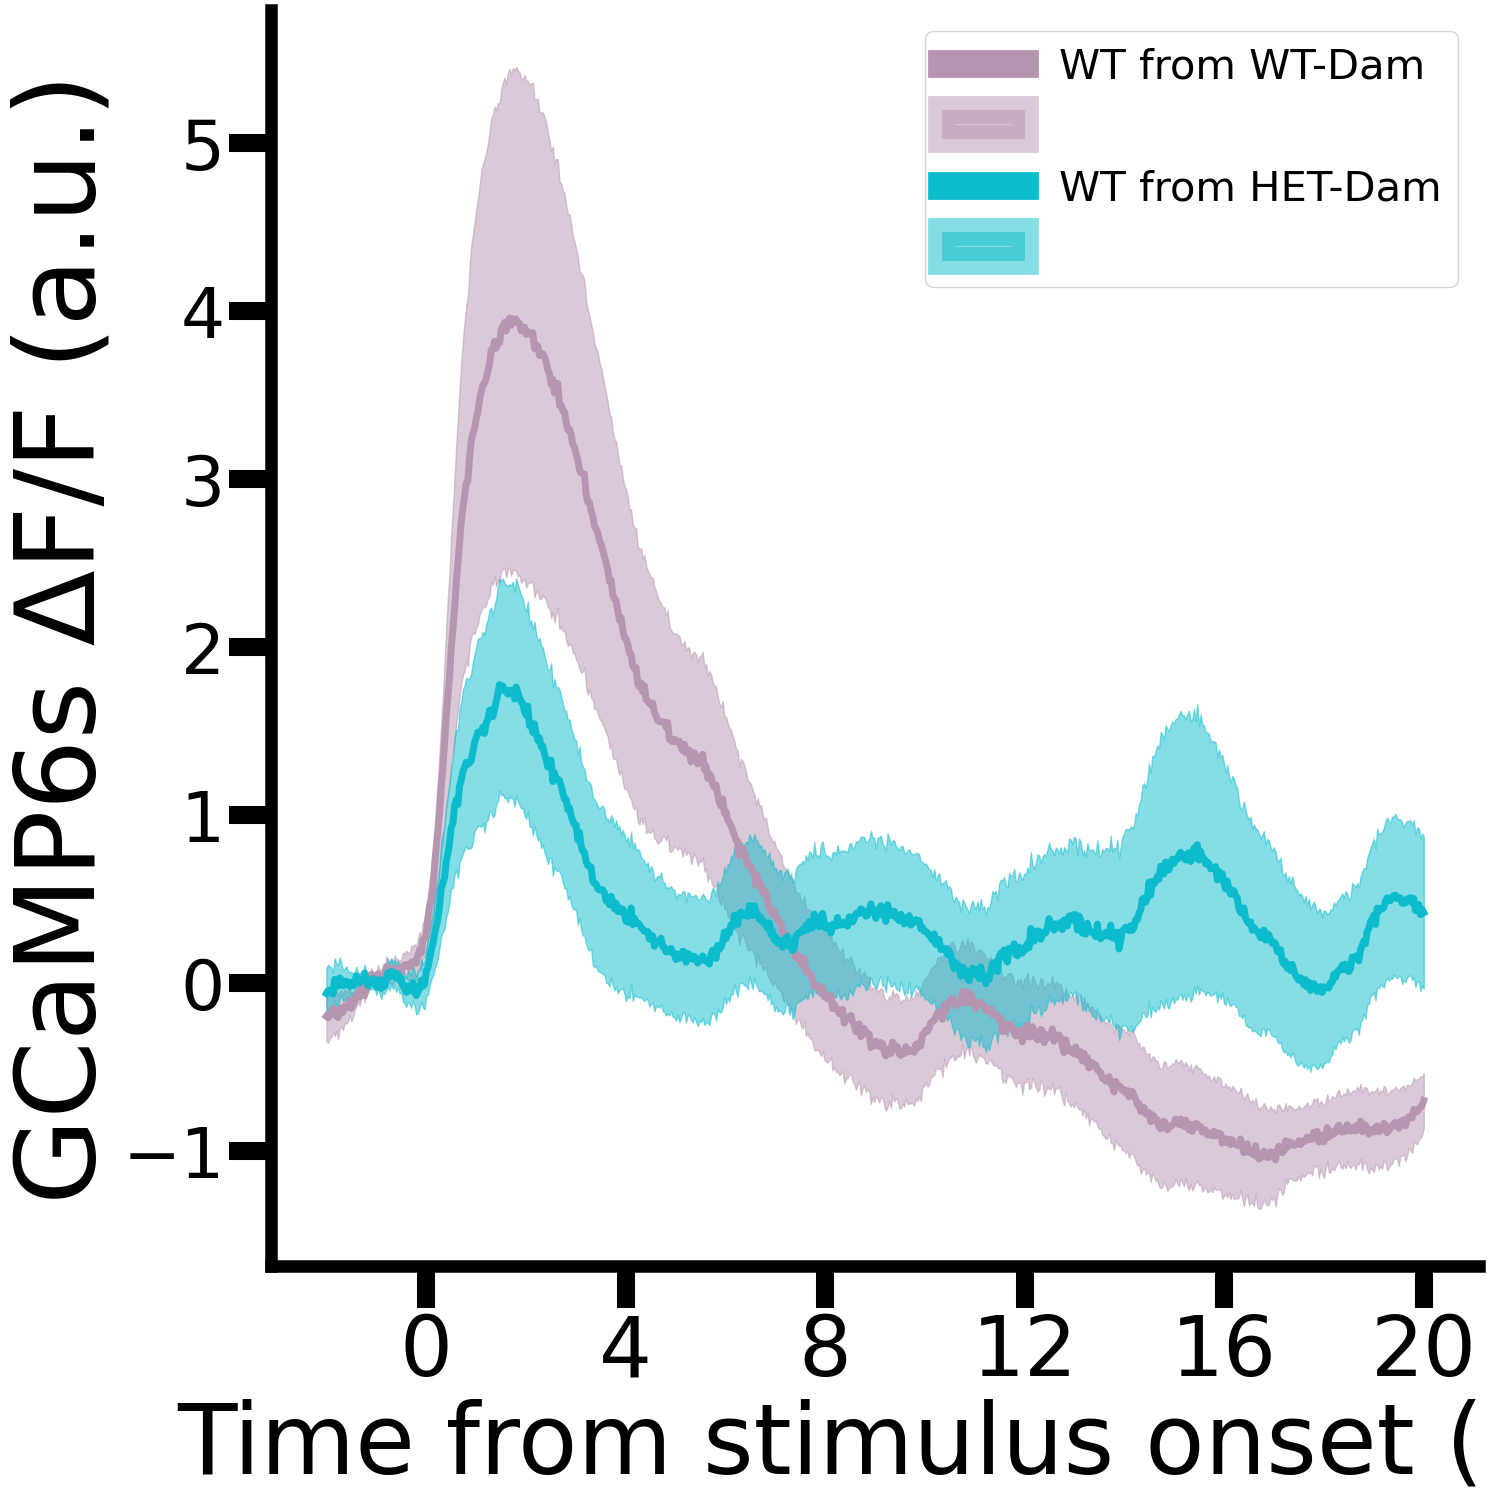

In [54]:
#14-16 response
df['Whisker_response_trace_cropped'] = None
for i, row in df.iterrows():

        try:
            df.at[i,'Whisker_response_trace_cropped'] = row['Whisker_response_trace'][:660]
        except:
            pass
plt.figure(figsize=(15,15))
PdA.Response(df,parameter='Whisker_response_trace_cropped', length = 660, genotypes=['Control','WT'], ages=[7,8,9,10], color = [color1,color2],title = None,sp_row=1,sp_colomn=1,sp_number=1,stat = np.nanmean)

leg = plt.legend(['WT from WT-Dam','','WT from HET-Dam',''],fontsize=30)
for leg in leg.legendHandles:
    leg.set_linewidth(20)
plt.xlabel('Time from stimulus onset (s)',fontsize=70)
#replace x ticks at time 0,60,120,.. 660 with -2,0,2,.. 20
plt.xticks(np.linspace(0,600,6),np.linspace(0,20,6).astype(int),fontsize=60)
#plt.yticks(np.arange(-1,0.6,0.5),fontsize=50)
plt.ylabel('GCaMP6s ΔF/F (a.u.)',fontsize=80)

#save figure
plt.savefig(Save_path + 'Whisker_response_22s_p7-10.svg',dpi=300,bbox_inches='tight',format='svg')


c:\Users\gabrielos\anaconda3\lib\site-packages\pandas\core\missing.py:94: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= arr == x


ShapiroResult(statistic=0.8512663245201111, pvalue=0.038060083985328674)
Ttest_indResult(statistic=1.641295186711863, pvalue=0.11325855411838082)
MannwhitneyuResult(statistic=116.0, pvalue=0.21339925437636265)


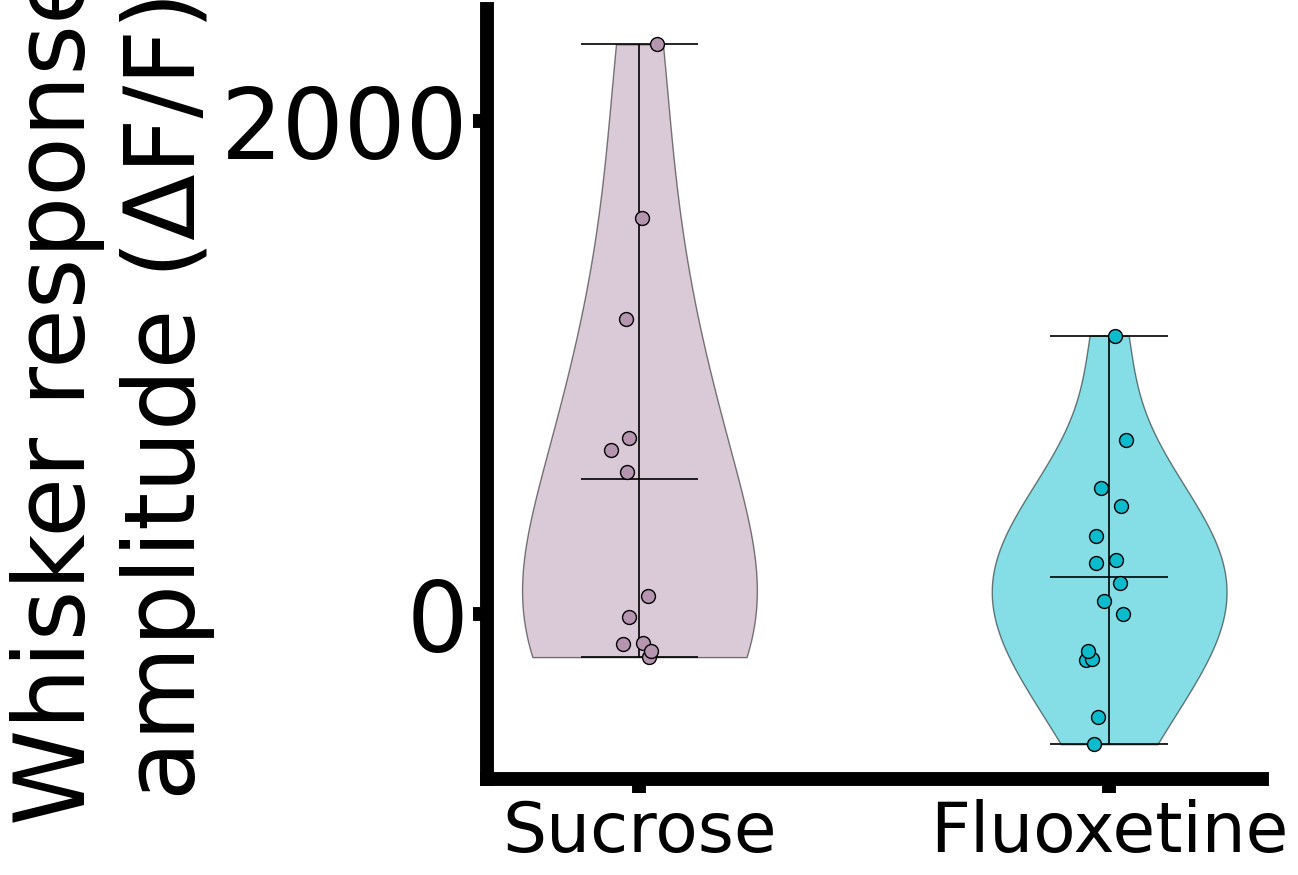

In [63]:
#df = df[df['Neurons']>300]
#Calculate AUC in the cropped traces and store it in a new column called 'Whisker_response_AUC_cropped'
df['Whisker_response_trace_cropped'] = None
df['Whisker_response_AUC_cropped'] = np.nan
for i, row in df.iterrows():
 #if row['Whisker_responsive']>=0.01: 
    #try:
    #tmp =  row['Whisker_response_trace'][:660]
    #If it is np.nan, remove this row from df_tmp
    #if np.isnan(tmp).any():
     #   df_tmp = df.drop(i)
   # else:
  if row['Whisker_responsive']>=0.00:
    try:
      tmp =  row['Whisker_response_trace'][:660]
      tmp = tmp - np.nanmean(tmp[0:60])
      df.at[i,'Whisker_response_trace_cropped'] = tmp
      #if it is nan or none, remove it
      df.at[i,'Whisker_response_AUC_cropped'] = np.trapz(tmp[60:300])
    except:
      df.at[i,'Whisker_response_AUC_cropped'] = np.nan
  else:
    df.at[i,'Whisker_response_AUC_cropped'] = np.nan
#7-10 response
df_control_SSRI = df[(df['genotype']=='Control') | (df['genotype']=='WT')]
#Replace control for 0 and ssri for 1
df_control_SSRI = df_control_SSRI.replace('Control',0)
df_control_SSRI = df_control_SSRI.replace('WT',1)
#select age <11
df_control_SSRI = df_control_SSRI[(df_control_SSRI['age']>6) & (df_control_SSRI['age']<10)]

#Mean across ages
df_control_SSRI = df_control_SSRI.groupby(['animal','genotype']).mean().reset_index()
#Remove nans in whisker response AUC
df_control_SSRI = df_control_SSRI[df_control_SSRI['Whisker_response_AUC_cropped'].notnull()]
#shapiro
print(stats.shapiro(df_control_SSRI[df_control_SSRI['genotype']==0]['Whisker_response_AUC_cropped']))
#remove nans

#Run t test
print(stats.ttest_ind(df_control_SSRI[df_control_SSRI['genotype']==0]['Whisker_response_AUC_cropped'],df_control_SSRI[df_control_SSRI['genotype']==1]['Whisker_response_AUC_cropped']))
#mann whitney u test
print(stats.mannwhitneyu(df_control_SSRI[df_control_SSRI['genotype']==0]['Whisker_response_AUC_cropped'],df_control_SSRI[df_control_SSRI['genotype']==1]['Whisker_response_AUC_cropped']))
#Plot violin plot
plt.figure(figsize=(10,10))
PdA.violin_plot(df[(df['age']>6) & (df['age']<10)],parameter='Whisker_response_AUC_cropped' , genotypes=['Control','WT'], y_label = 'Whisker response\namplitude (ΔF/F)', color = [color1,color2],title = None, fontsize = 70)

#set  xticks as 'Sucrose' and 'Fluoxetine'
#plt.yticks(np.arange(0,21,10),fontsize=50)
plt.xticks([1,2],['Sucrose','Fluoxetine'],fontsize=50)
plt.savefig(Save_path + 'REAL_P7_10_Whisker_response_AUC_violin.svg', dpi=300, bbox_inches='tight')

## Correlation distance

In [168]:
#To account for correlations in the edge introducing noise, crop
#Make new colomn with cropped traces
df['Correlations_distance_cropped'] = None
for i, row in df.iterrows():
    try:
        df.at[i,'Correlations_distance_cropped'] = np.array(row['Correlations_distance'][:10])
    except:
        pass

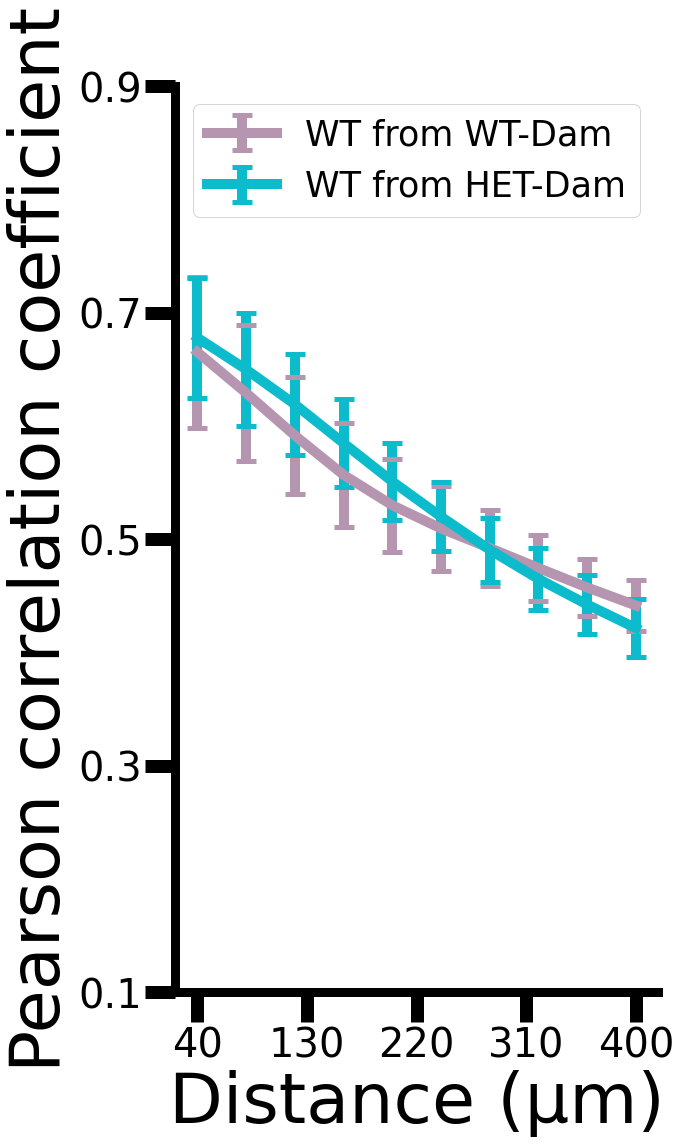

In [180]:

plt.figure(figsize=(10,15))
PdA.Corr_distance_plot(df,parameter='Correlations_distance_cropped', genotypes=['Control','WT'], ages=[8], color = [color1,color2],title = None,sp_row=1,sp_colomn=1,sp_number=1)
plt.ylim([0.1,0.85])
leg = plt.legend(['WT from WT-Dam','WT from HET-Dam'],fontsize=35)
for leg in leg.legendHandles:
    leg.set_linewidth(10.0)
#Set xticks from 0 to 10 as 40 to 400
plt.xticks(np.linspace(0,9,5),np.linspace(40,400,5).astype(int),fontsize=40)
plt.yticks(np.arange(0.1,1,0.2),fontsize=40)
#Savefig
plt.savefig(Save_path + 'Maternal_phenotype_P8_Correlations_distance.svg',bbox_inches='tight',dpi=300)


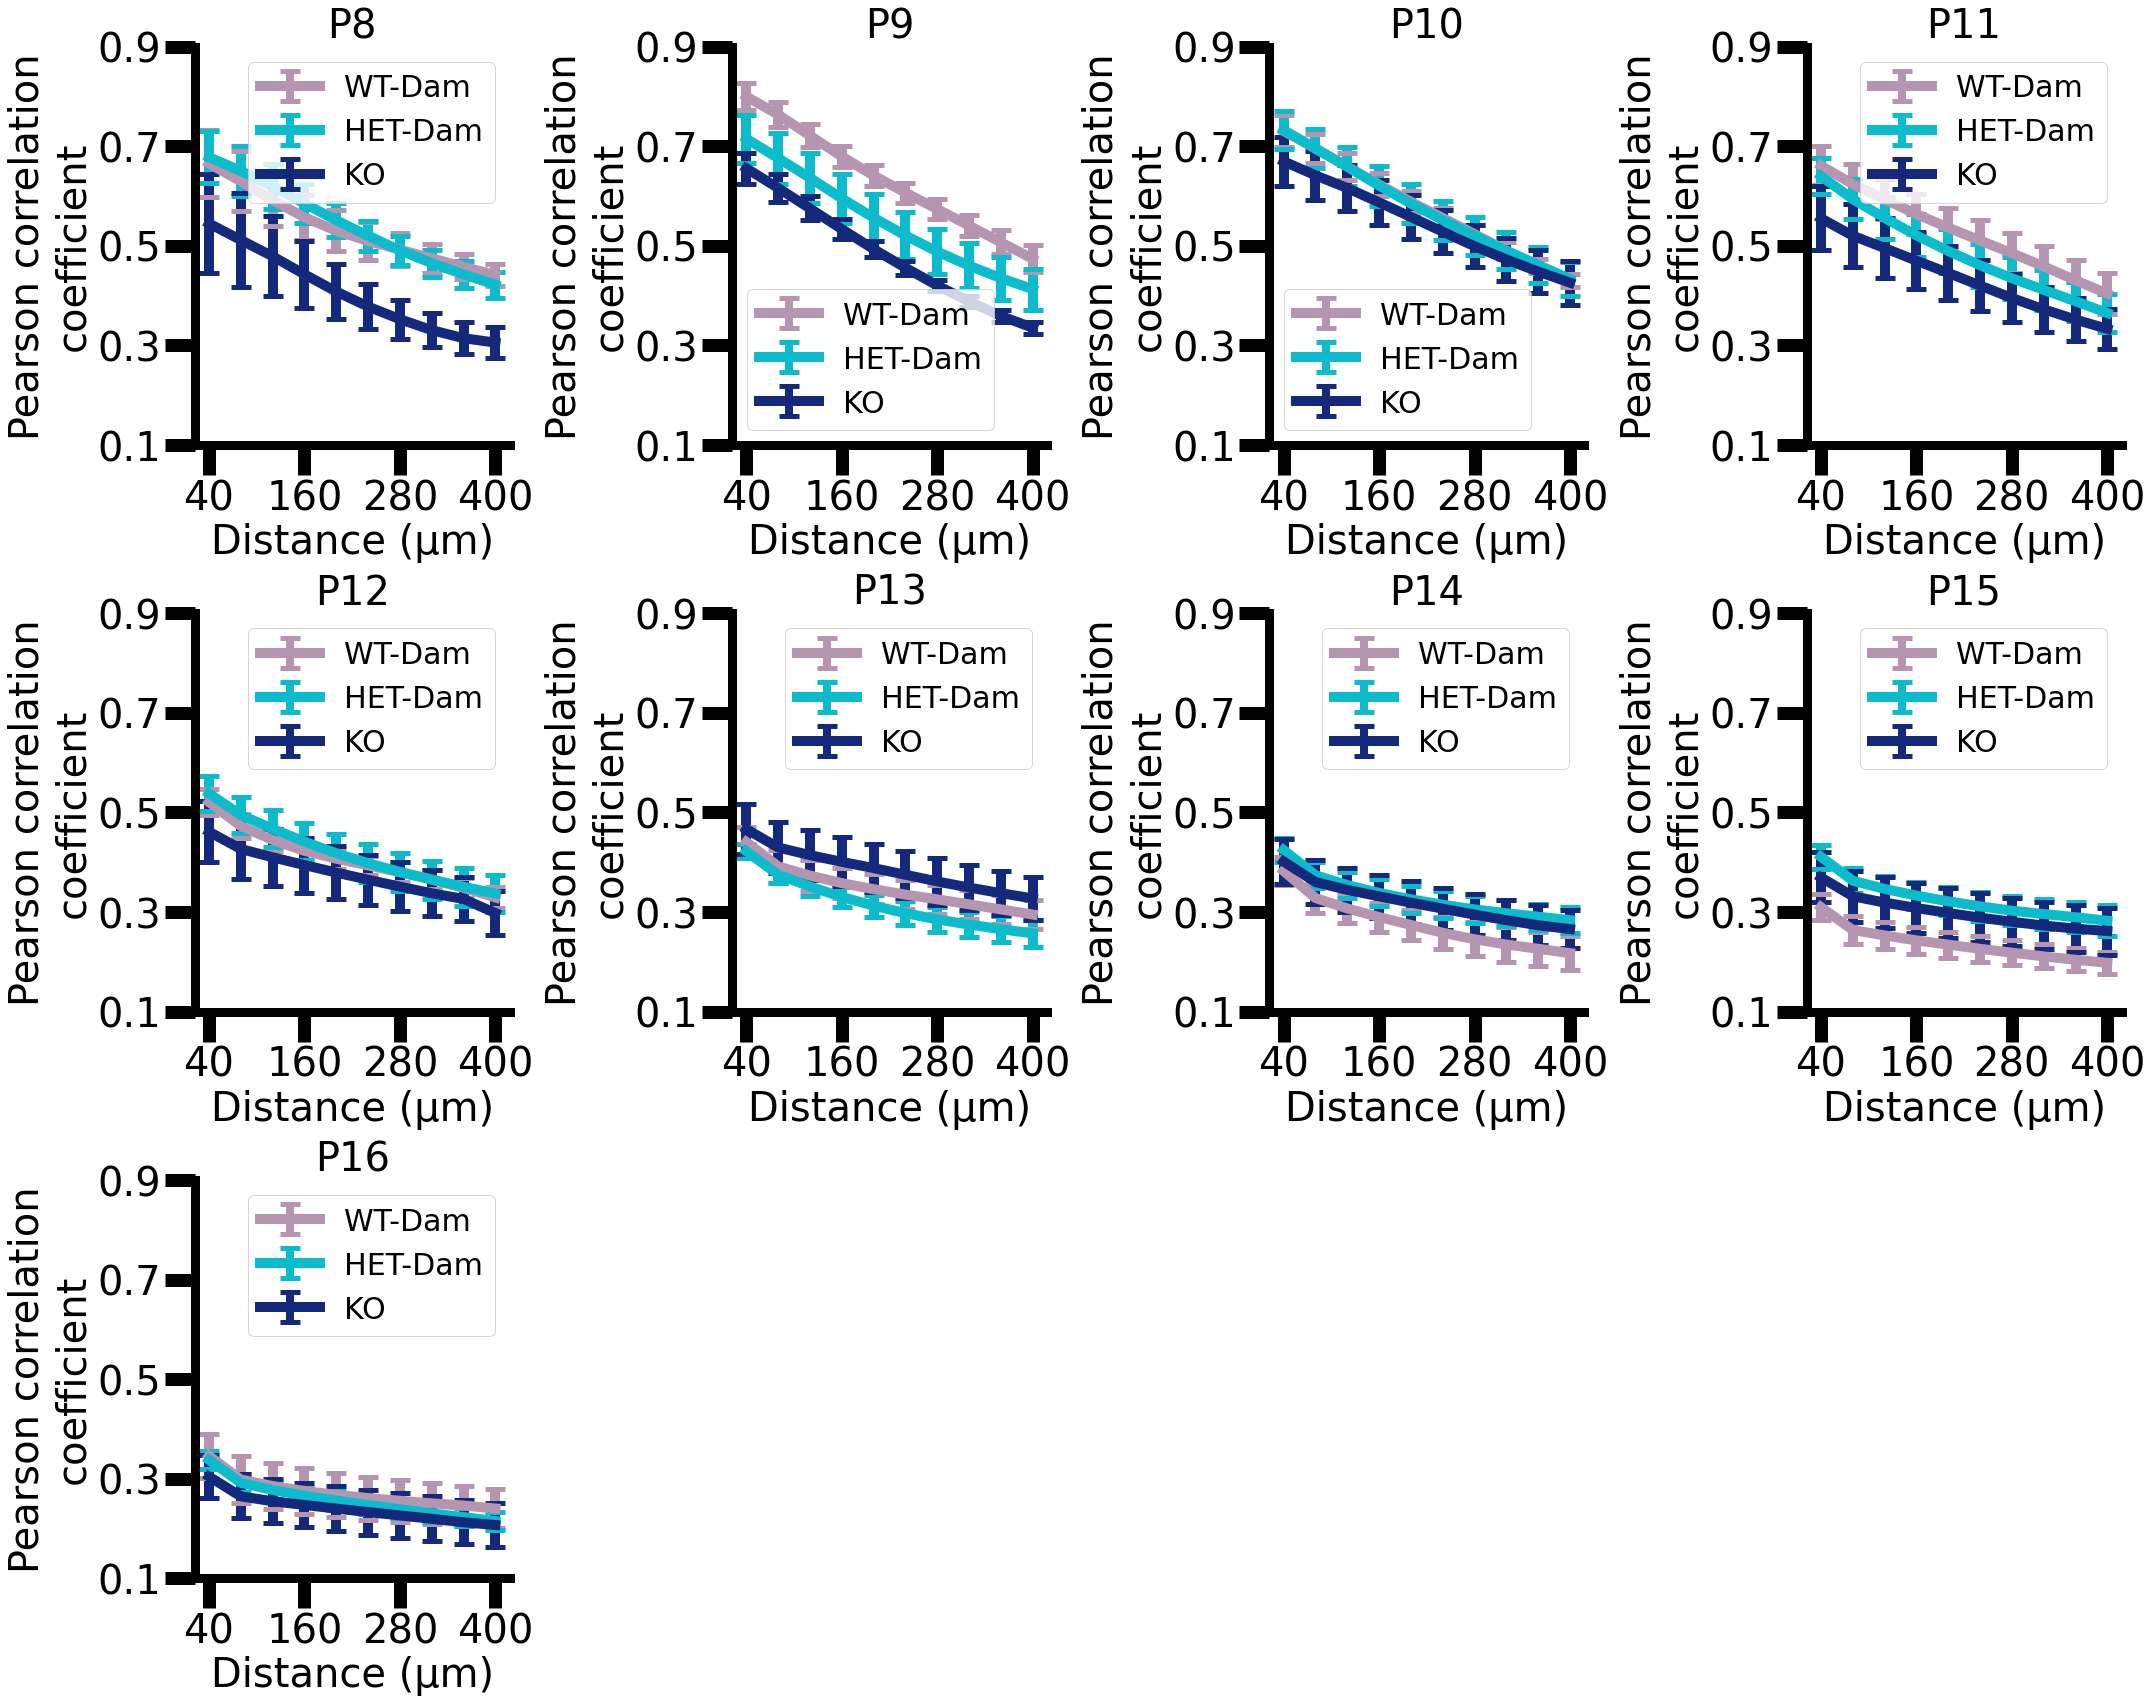

In [182]:
plt.figure(figsize=(30,30))
for i in range(8,17):
    plt.subplot(4,4,i-7)
    PdA.Corr_distance_plot(df,parameter='Correlations_distance_cropped', genotypes=['Control','WT','KO'], ages=[i], color = [color1,color2,color4],title = None,sp_row=4,sp_colomn=4,sp_number=i-7)
    plt.ylim([0.1,0.85])
    leg = plt.legend(['WT-Dam','HET-Dam','KO'],fontsize=30)
    for leg in leg.legendHandles:
        leg.set_linewidth(8.0)
    #Set xticks from 0 to 10 as 40 to 400
    plt.xticks(np.linspace(0,9,4),np.linspace(40,400,4).astype(int),fontsize=40)
    plt.yticks(np.arange(0.1,1,0.2),fontsize=40)
    plt.ylabel('Pearson correlation\ncoefficient', fontsize=40)
    plt.title('P' + str(i),fontsize=40)
    plt.xlabel('Distance (μm)',fontsize=40)
    plt.tight_layout()
    
    #Savefig
    plt.savefig(Save_path + 'Maternal_phenotype_ALL_Correlations_distance_with_ssri.svg',bbox_inches='tight',dpi=300)

# Supplementary

#### Dissimilarity

In [224]:
Path_df = '//qnap-amp001.dpag.ox.ac.uk/gsantero/Analysis/Data_frames/With_data/'
file_name = '2023_10_24_df_data_INT'

#import 2023_03_18_df_cumsum as df_cumsum using pickle
with open(Path_df + file_name,'rb') as handle:
    df = pickle.load(handle)



df['interneuron'] = df['interneuron'].replace('NKx2.1','Nkx2.1')
df['genotype'] = df['genotype'].replace('KO ','KO')
df['genotype'] = df['genotype'].replace('HET ','HET')
df['genotype'] = df['genotype'].replace('WT ','WT')
df['genotype'] = df['genotype'].replace('WT?','WT')

#extract_to_separate_coloumn number of neurons to separate coloumn
df = PdA.extract_to_separate_coloumn(df,'Number_of_neurons',0,'Neurons')
df = PdA.extract_to_separate_coloumn(df, 'Whisker_responses',-3,'Proportion_resp')
for n in range(0,10):
    df = PdA.extract_to_separate_coloumn(df, 'Whisker_responses',n,'Resp' + str((n+1)*10) + '%')
for n in range(0,10):
    df = PdA.extract_to_separate_coloumn(df, 'Airpuff_responses',n,'AResp' + str((n+1)*10) + '%')
df = PdA.extract_to_separate_coloumn(df, 'Whisker_responses',-3,'Whisker_responsive')
df = PdA.extract_to_separate_coloumn(df, 'Airpuff_responses',-3,'Airpuff_responsive')


#Remove rows with less than 500 neuorns and print how many where removed
print('Number of rows removed: ' + str(len(df[df['Neurons'] < 500])))
#df = df[df['Neurons'] >= 500]

#remove runt 351 (died at P10 very underweighted)
df = df[df['animal'] != 'GOS351']
df.head(n=10)

#remove GOS464 ONWARDS (WT dams)
df = df[df['animal'] != 'GOS466']
df = df[df['animal'] != 'GOS470']
df = df[df['animal'] != 'GOS471']



Number of rows removed: 54


C:\Users\GABRIE~1\AppData\Local\Temp/ipykernel_111716/1748477860.py:8: RuntimeWarning: Mean of empty slice
  df.loc[i,'similarity_mean_airpuff'] = np.nanmean(row['similarity_cd_airpuff'])


ShapiroResult(statistic=0.9454820156097412, pvalue=0.003075049025937915)
KruskalResult(statistic=0.15745767745767125, pvalue=0.6915080393123834)
SERTKO Age: 7
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower  upper  reject
----------------------------------------------------
Control   SSRI  -0.1638 0.0852 -0.3549 0.0273  False
----------------------------------------------------
SERTKO Age: 8
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower  upper  reject
----------------------------------------------------
Control   SSRI   0.0142 0.8691 -0.1628 0.1912  False
----------------------------------------------------
SERTKO Age: 9
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1 group2 meandiff p-adj   lower  upper  reject
----------------------------------------------------
Control   SSRI   0.0468 0.4975 -0.0966 0.1902  False
----------------------------------------------------
SERTKO Age: 10
Mul

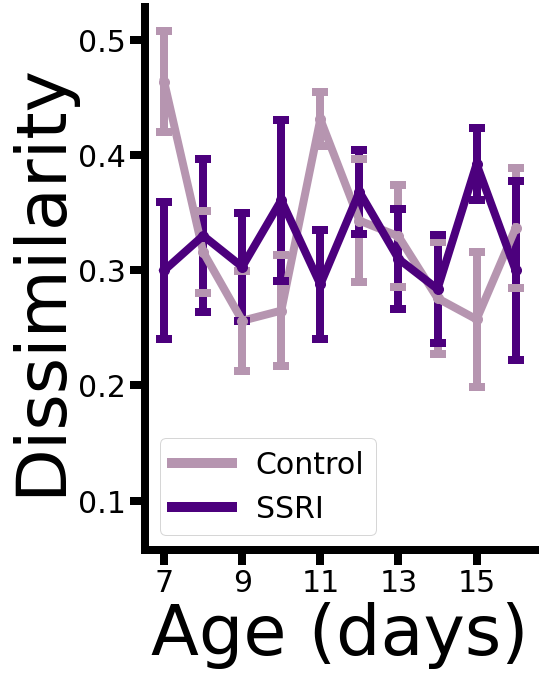

In [228]:
# Load, plot and stats dissimilarity across development, only P13 significant!
df['similarity_mean_airpuff'] = None
#make similarity_cd float
#df['similarity_cd'] = df['similarity_cd'].astype(float)
#mean
for i,row in df.iterrows():
    try:
        df.loc[i,'similarity_mean_airpuff'] = np.nanmean(row['similarity_cd_airpuff'])
    except:
        pass
plt.figure(figsize=(7,10))
PdA.developmental_plot_errorbars(df,'similarity_mean_airpuff',y_label='Similarity', genotype=['Control','SSRI'],color=[color1,color2])
plt.xlim([-0.5,9.5])
plt.ylabel('Dissimilarity',fontsize=70)
plt.xlabel('Age (days)',fontsize=70)
plt.savefig(Save_path + 'Air_puff_Similarity_across_dev.svg',dpi=300,bbox_inches='tight')


#Krustal wallis
df_tmp = df.copy()

#Remove mean_correlation nones
df_tmp = df_tmp[df_tmp['similarity_mean_airpuff'].notna()]
#,ake float
df_tmp['similarity_mean_airpuff'] = df_tmp['similarity_mean_airpuff'].astype(float)
#age <17
df_tmp = df_tmp[df_tmp['age']<17]
#Shapiro 
print(stats.shapiro(df_tmp[df_tmp['genotype']=='Control']['similarity_mean_airpuff']))
print(stats.kruskal(df_tmp[df_tmp['genotype']=='Control']['similarity_mean_airpuff'],df_tmp[df_tmp['genotype']=='SSRI']['similarity_mean_airpuff']))
for age in range(7,17):
    print('SERTKO Age: ' + str(age))
    df_tmp = df[df['age']==age]
    #Select only WT, HET and KO
    df_tmp = df_tmp[df_tmp['genotype'].isin(['Control','SSRI'])]
    #Make float entropy
    df_tmp['similarity_mean_airpuff'] = df_tmp['similarity_mean_airpuff'].astype(float)
    #Remove none and nans on entropy
    df_tmp = df_tmp[df_tmp['similarity_mean_airpuff'].notnull()]
    #Select only WT, HET, KO
    #df_tmp = df_tmp[df_tmp['genotype']!='Control']
    #df_tmp = df_tmp[df_tmp['genotype']!='SSRI']
    #Run tukey test
    print(tukey.MultiComparison(df_tmp['similarity_mean_airpuff'],df_tmp['genotype']).tukeyhsd().summary())

ShapiroResult(statistic=0.9474974870681763, pvalue=0.6389961838722229)
F_onewayResult(statistic=0.40561847359843045, pvalue=0.5326851471376954)
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.0263 0.5373 -0.0607 0.1133  False
---------------------------------------------------


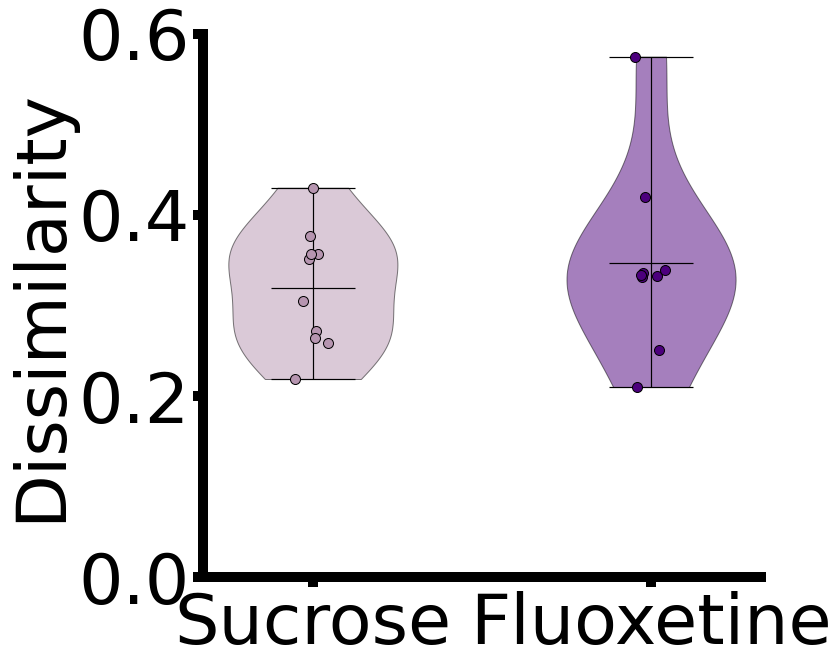

In [232]:
#Mean across developmental window
#Plot
df_tmp = df.copy()
#remove null
plt.figure(figsize=(10,10))
df_tmp = df_tmp[df_tmp['similarity_mean_airpuff'].notnull()]
PdA.violin_plot(df_tmp,'similarity_mean_airpuff',y_label='Dissimilarity', genotypes=['Control','SSRI'],color=[color1,color2])
plt.ylim([0,0.6])
#XTICKS Sucrose and Fluoxetine
plt.xticks([1,2],['Sucrose','Fluoxetine'],fontsize=70)
plt.savefig(Save_path + 'violin_plot_Air_puff_Dissimilarity.svg',dpi=300,bbox_inches='tight')

#Stats
df_tmp = df[df['age']<17].copy()
#Select only Control, SSRI
df_tmp = df_tmp[df_tmp['genotype']!='WT']
df_tmp = df_tmp[df_tmp['genotype']!='HET']
df_tmp = df_tmp[df_tmp['genotype']!='KO']
#df_tmp = df_tmp[df_tmp['genotype']!='KO']
#Replace genotype by 0,1,2
df_tmp['genotype'] = df_tmp['genotype'].replace('Control',0)
df_tmp['genotype'] = df_tmp['genotype'].replace('SSRI',1)

#Make entropy float
df_tmp['similarity_mean_airpuff'] = df_tmp['similarity_mean_airpuff'].astype(float)
#Group by animal
df_tmp = df_tmp.groupby(['animal']).mean()
#Remove nans
df_tmp = df_tmp[df_tmp['similarity_mean_airpuff'].notnull()]
print(stats.shapiro(df_tmp[df_tmp['genotype']==0]['similarity_mean_airpuff']))
#One way ANOVA
print(stats.f_oneway(df_tmp[df_tmp['genotype']==0]['similarity_mean_airpuff'],df_tmp[df_tmp['genotype']==1]['similarity_mean_airpuff']))
#tukey test
print(tukey.MultiComparison(df_tmp['similarity_mean_airpuff'],df_tmp['genotype']).tukeyhsd().summary())

